### Библиотеки

In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.image as mpimg
import hashlib
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import shutil
from torchvision.datasets import ImageFolder

### Загружаем данные

In [3]:
%pip install -q kaggle
#from google.colab import files
#files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c dl-2025-competition-1 --force
!unzip -o dl-2025-competition-1.zip


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: python3 -m pip install --upgrade pip



100%|██████████| 31.4M/31.4M [00:02<00:00, 15.4MB/s]


Archive:  dl-2025-competition-1.zip
  inflating: data/test/0.png         
  inflating: data/test/1.png         
  inflating: data/test/10.png        
  inflating: data/test/100.png       
  inflating: data/test/1000.png      
  inflating: data/test/1001.png      
  inflating: data/test/1002.png      
  inflating: data/test/1003.png      
  inflating: data/test/1004.png      
  inflating: data/test/1005.png      
  inflating: data/test/1006.png      
  inflating: data/test/1007.png      
  inflating: data/test/1008.png      
  inflating: data/test/1009.png      
  inflating: data/test/101.png       
  inflating: data/test/1010.png      
  inflating: data/test/1011.png      
  inflating: data/test/1012.png      
  inflating: data/test/1013.png      
  inflating: data/test/1014.png      
  inflating: data/test/1015.png      
  inflating: data/test/1016.png      
  inflating: data/test/1017.png      
  inflating: data/test/1018.png      
  inflating: data/test/1019.png      
  inflating: d

In [4]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.shape

(3878, 2)

In [7]:
train_dir = 'data/train'
test_dir = 'data/test'

### Просто картинка

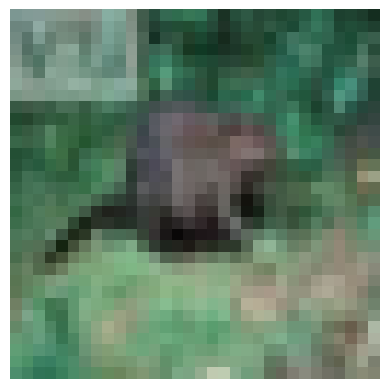

In [3]:
image_path = "data/test/3873.png"
img = Image.open(image_path)

plt.imshow(img)
plt.axis("off")
plt.show()

### Смотрим количество классов, изображений, изображений в классах

In [ ]:
num_train_images = 0
num_classes = 0
for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        print(f"Класс {class_name}: {num_images} изображений")
        num_train_images += num_images
        num_classes += 1

print(f"\nВсего классов в train: {num_classes}")
print(f"Всего изображений в train: {num_train_images}")

num_test_images = len(os.listdir(test_dir))
print(f"\nВсего изображений в test: {num_test_images}")

Класс 70: 38 изображений
Класс 60: 37 изображений
Класс 31: 78 изображений
Класс 99: 72 изображений
Класс 87: 106 изображений
Класс 39: 104 изображений
Класс 41: 149 изображений
Класс 58: 80 изображений
Класс 79: 88 изображений
Класс 90: 34 изображений
Класс 15: 137 изображений
Класс 74: 138 изображений
Класс 35: 72 изображений
Класс 30: 128 изображений
Класс 36: 118 изображений
Класс 66: 111 изображений
Класс 56: 139 изображений
Класс 43: 34 изображений
Класс 81: 48 изображений
Класс 26: 44 изображений
Класс 44: 135 изображений
Класс 96: 61 изображений
Класс 61: 80 изображений
Класс 23: 32 изображений
Класс 46: 95 изображений
Класс 48: 70 изображений
Класс 38: 125 изображений
Класс 19: 87 изображений
Класс 33: 46 изображений
Класс 92: 106 изображений
Класс 0: 110 изображений
Класс 52: 127 изображений
Класс 3: 119 изображений
Класс 75: 63 изображений
Класс 29: 118 изображений
Класс 1: 109 изображений
Класс 59: 146 изображений
Класс 28: 149 изображений
Класс 27: 128 изображений
Класс 13

### Гистограмма баланса классов

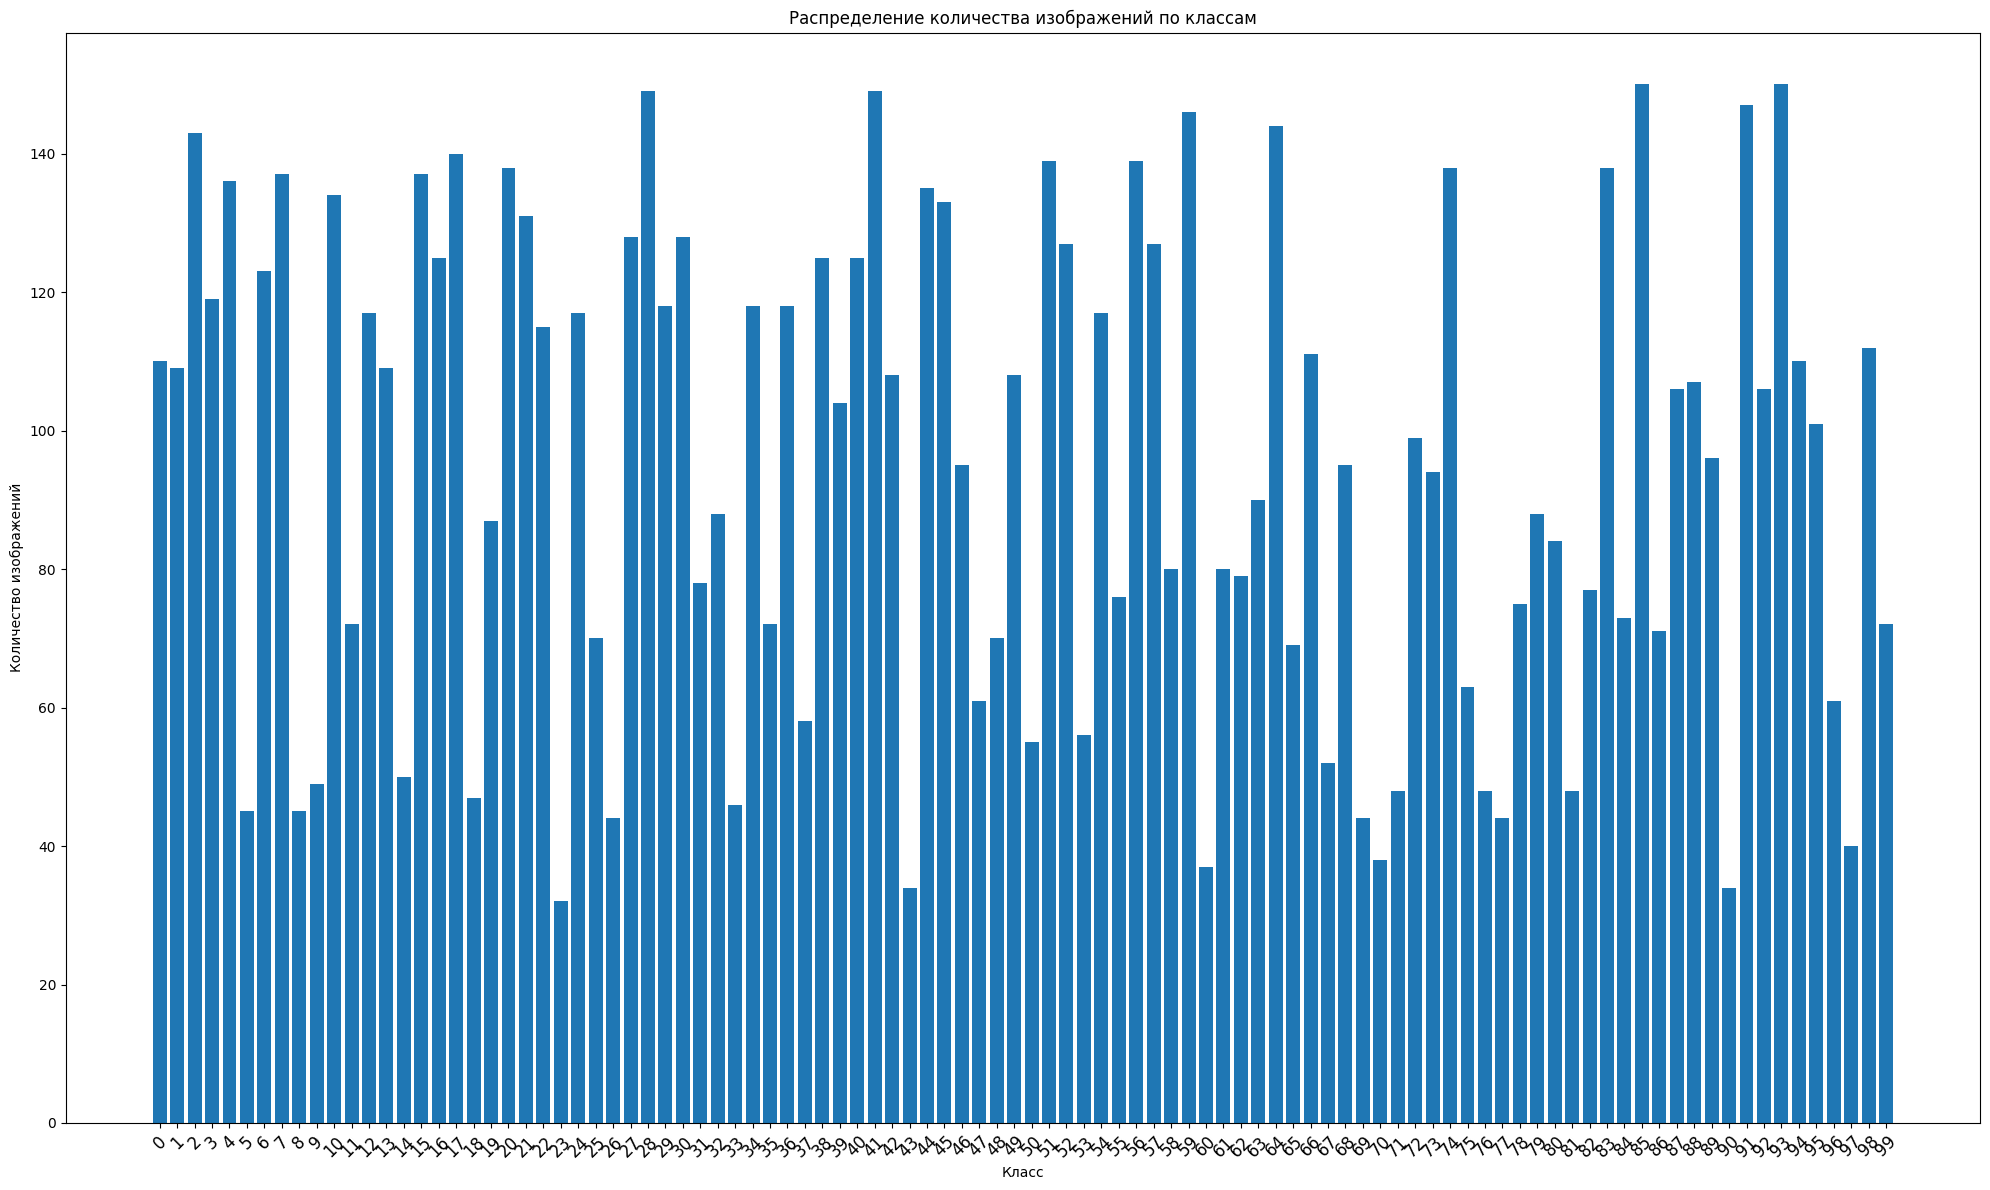

In [ ]:
class_counts = []
class_names = []
for class_name in sorted(os.listdir(train_dir), key=int):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        class_counts.append(num_images)
        class_names.append(class_name)

plt.figure(figsize=(20, 12))
plt.bar(class_names, class_counts)
plt.xlabel('Класс')
plt.ylabel('Количество изображений')
plt.title('Распределение количества изображений по классам')
plt.xticks(rotation=45, size=12)
plt.tight_layout()
plt.show()

### Проверим размерность всех картинок

In [ ]:
def check_image_dimensions(data_dir, expected_width=32, expected_height=32):
    count = 0
    for filename in os.listdir(data_dir):
        if filename.endswith(('.png')):
            image_path = os.path.join(data_dir, filename)
            img = mpimg.imread(image_path)

            height, width, _ = img.shape if len(img.shape) == 3 else (img.shape[0], img.shape[1], 1)

            if width != expected_width or height != expected_height:
                print(f"Размерность изображения {filename} не {expected_width}x{expected_height}: {width}x{height}")
                count +=1

    if count == 0:
        print(f"Все изображения имеют размер {expected_width}x{expected_height}")


check_image_dimensions(train_dir)
check_image_dimensions(test_dir)

Все изображения имеют размер 32x32
Все изображения имеют размер 32x32


### Нарисуем 5 рандомных картинок из каждого класса (train_dir)

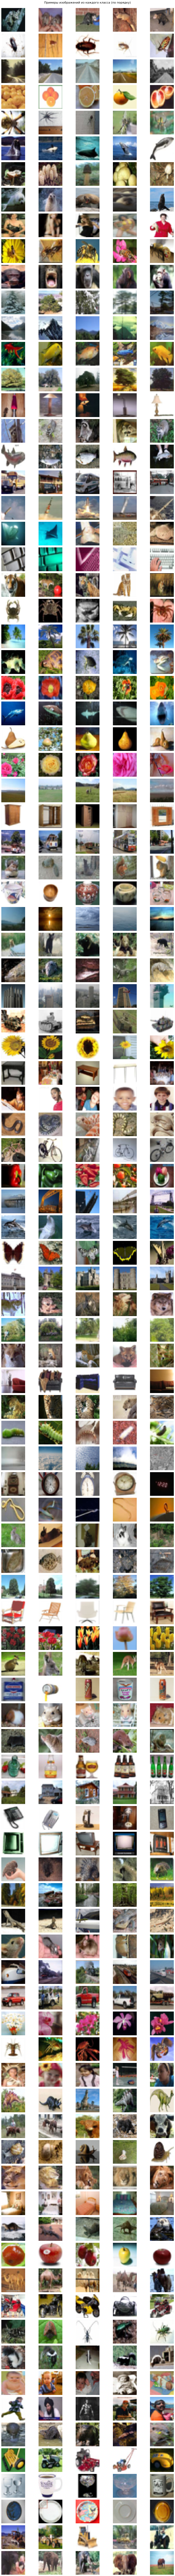

In [ ]:
num_images_per_class = 5

class_names = sorted(os.listdir(train_dir), key=int)

num_classes = len(class_names)
fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(15, num_classes * 2))
fig.suptitle("Примеры изображений из каждого класса (по порядку)", fontsize=16)


for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_dir) if f.endswith(('.png'))]
    # Выбираем случайные изображения
    indices = random.sample(range(len(image_files)), num_images_per_class)

    for j, index in enumerate(indices):
        image_path = os.path.join(class_dir, image_files[index])
        img = mpimg.imread(image_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_ylabel(class_name, rotation=90, size='large')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Рандомные 5 картинок из test_dir

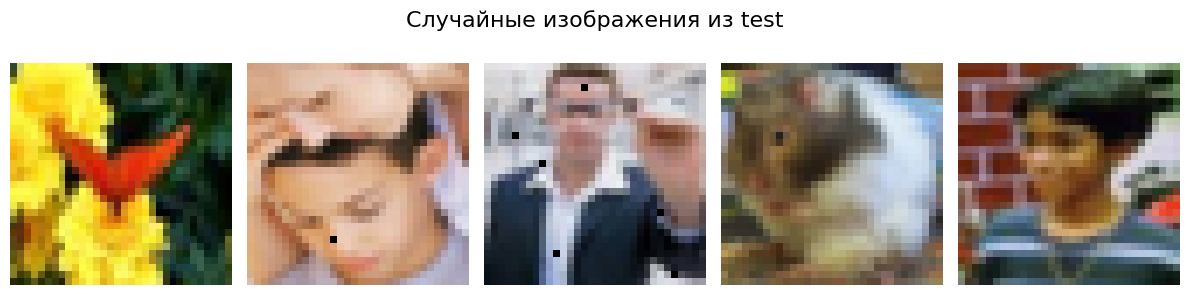

In [ ]:
num_images_to_display = 5

image_files = [f for f in os.listdir(test_dir) if f.endswith(('.png'))]

num_images = len(image_files)
indices = random.sample(range(num_images), min(num_images_to_display, num_images))

num_cols = min(num_images_to_display, num_images)
fig, axes = plt.subplots(1, num_cols, figsize=(12, 3))
fig.suptitle("Случайные изображения из test", fontsize=16)

for i, index in enumerate(indices):
    image_path = os.path.join(test_dir, image_files[index])
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Проверим размерность каналов

In [ ]:
def check_images(image_folder):
    all_rgb = True
    for filename in os.listdir(image_folder):
        if filename.endswith(('.png')):
            filepath = os.path.join(image_folder, filename)
            img = cv2.imread(filepath)
            if not (img.ndim == 3 and img.shape[2] == 3):
                print(f"{filename}: Не RGB или не 3 канала, форма: {img.shape}")
                all_rgb = False

    if all_rgb == True:
        print(f"Все картинки RGB, 3 канала")


check_images(train_dir)
check_images(test_dir)

Все картинки RGB, 3 канала
Все картинки RGB, 3 канала


### Дубликаты?

In [ ]:
def find_duplicates_hash(image_folder):
    hashes = {}
    duplicates = []
    for filename in os.listdir(image_folder):
        if filename.endswith(('.png')):
            filepath = os.path.join(image_folder, filename)
            with open(filepath, 'rb') as f:
                filehash = hashlib.md5(f.read()).hexdigest()
            if filehash in hashes:
                duplicates.append((filename, hashes[filehash]))
            else:
                hashes[filehash] = filename
    return duplicates


duplicates = find_duplicates_hash(train_dir)

if duplicates:
    print(f"Найдены дубликаты в {train_dir}:")
    for dup in duplicates:
        print(f" {dup[0]} дубликат {dup[1]}")
else:
    print(f"Дубликаты не найдены.")

Дубликаты не найдены.


In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda:0


#### mean & std

In [8]:
transform = transforms.ToTensor()
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=4)

mean = 0.
std = 0.
nb_samples = 0.
for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.5069, 0.4869, 0.4403])
Std: tensor([0.1999, 0.1975, 0.2014])


### Делим на train и val

In [9]:
data_dir = 'data/train'
train_dir = 'data/split/train'
val_dir = 'data/split/val'
test_dir = 'data/test'

# Создание новых директорий
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Проход по каждому классу
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

class SortedImageFolder(ImageFolder): #для правильной сортировки классов
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
        classes = sorted(classes, key=lambda x: int(x))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

class AlbumentationsTransform:
    def __init__(self, augmentations):
        self.augmentations = augmentations

    def __call__(self, img):
        img = np.array(img)
        augmented = self.augmentations(image=img)
        return augmented['image']

In [10]:
class EarlyStopping: #для ранней остановки
    def __init__(self, patience=7):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_acc):
        if self.best_score is None:
            self.best_score = val_acc
        elif val_acc < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_acc
            self.counter = 0

## Mobilenet_v2

### Модель с transfer learning(mobilenet_v2) и без навороченных аугментаций

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 237/237 [00:08<00:00, 28.41it/s]


Epoch 1/30 | Train Loss: 3.9758 | Train Acc: 0.1111 | Val Loss: 3.3812 | Val Acc: 0.1749
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 27.38it/s]


Epoch 2/30 | Train Loss: 3.3662 | Train Acc: 0.1900 | Val Loss: 3.0467 | Val Acc: 0.2492
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 27.03it/s]


Epoch 3/30 | Train Loss: 2.7662 | Train Acc: 0.2880 | Val Loss: 2.6067 | Val Acc: 0.3173
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 28.92it/s]


Epoch 4/30 | Train Loss: 2.5510 | Train Acc: 0.3370 | Val Loss: 2.4943 | Val Acc: 0.3421
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 27.91it/s]


Epoch 5/30 | Train Loss: 2.3969 | Train Acc: 0.3604 | Val Loss: 2.4978 | Val Acc: 0.3395


100%|██████████| 237/237 [00:09<00:00, 24.05it/s]


Epoch 6/30 | Train Loss: 2.3761 | Train Acc: 0.3603 | Val Loss: 2.4585 | Val Acc: 0.3591
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 27.59it/s]


Epoch 7/30 | Train Loss: 2.3370 | Train Acc: 0.3726 | Val Loss: 2.4693 | Val Acc: 0.3483


100%|██████████| 237/237 [00:08<00:00, 27.54it/s]


Epoch 8/30 | Train Loss: 2.3683 | Train Acc: 0.3685 | Val Loss: 2.4715 | Val Acc: 0.3560


100%|██████████| 237/237 [00:08<00:00, 28.54it/s]


Epoch 9/30 | Train Loss: 2.3778 | Train Acc: 0.3652 | Val Loss: 2.4627 | Val Acc: 0.3509


100%|██████████| 237/237 [00:08<00:00, 29.50it/s]


Epoch 10/30 | Train Loss: 2.3623 | Train Acc: 0.3666 | Val Loss: 2.4547 | Val Acc: 0.3524


100%|██████████| 237/237 [00:08<00:00, 27.62it/s]


Epoch 11/30 | Train Loss: 2.3558 | Train Acc: 0.3689 | Val Loss: 2.4718 | Val Acc: 0.3504
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:08<00:00, 27.24it/s]


Epoch 12/30 | Train Loss: 2.9106 | Train Acc: 0.3694 | Val Loss: 3.0024 | Val Acc: 0.3452


100%|██████████| 237/237 [00:08<00:00, 27.22it/s]


Epoch 13/30 | Train Loss: 2.9131 | Train Acc: 0.3733 | Val Loss: 2.9921 | Val Acc: 0.3566
Early stopping triggered.


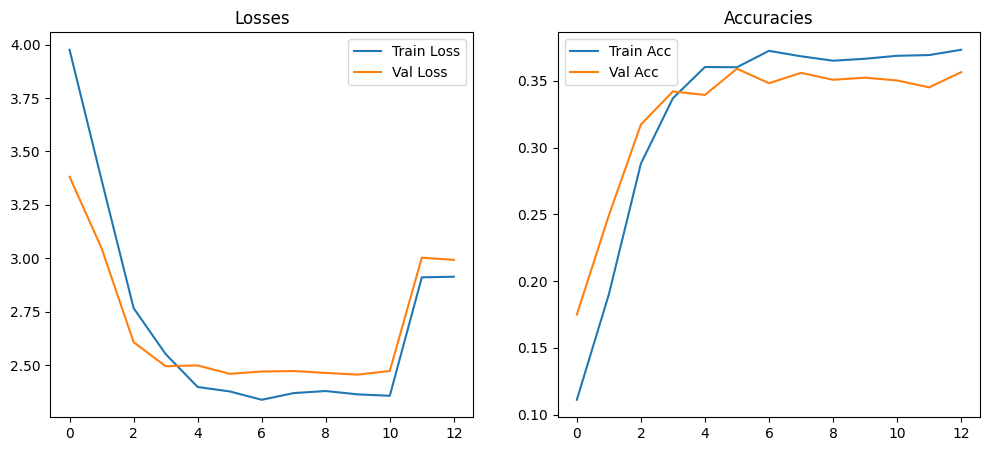

In [ ]:
#Пайплайн
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

### Добавим Resize в пайплайн

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 237/237 [00:37<00:00,  6.38it/s]


Epoch 1/30 | Train Loss: 3.3727 | Train Acc: 0.1886 | Val Loss: 2.7819 | Val Acc: 0.2962
Best model saved.


100%|██████████| 237/237 [00:34<00:00,  6.87it/s]


Epoch 2/30 | Train Loss: 2.4725 | Train Acc: 0.3456 | Val Loss: 2.4086 | Val Acc: 0.3782
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.72it/s]


Epoch 3/30 | Train Loss: 1.7403 | Train Acc: 0.5160 | Val Loss: 1.7409 | Val Acc: 0.4948
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.63it/s]


Epoch 4/30 | Train Loss: 1.4655 | Train Acc: 0.5866 | Val Loss: 1.6375 | Val Acc: 0.5155
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.73it/s]


Epoch 5/30 | Train Loss: 1.3247 | Train Acc: 0.6171 | Val Loss: 1.6146 | Val Acc: 0.5320
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.68it/s]


Epoch 6/30 | Train Loss: 1.3028 | Train Acc: 0.6286 | Val Loss: 1.6027 | Val Acc: 0.5330
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.72it/s]


Epoch 7/30 | Train Loss: 1.2748 | Train Acc: 0.6352 | Val Loss: 1.6094 | Val Acc: 0.5335
Best model saved.


100%|██████████| 237/237 [00:38<00:00,  6.11it/s]


Epoch 8/30 | Train Loss: 1.2736 | Train Acc: 0.6347 | Val Loss: 1.6051 | Val Acc: 0.5320


100%|██████████| 237/237 [00:35<00:00,  6.66it/s]


Epoch 9/30 | Train Loss: 1.2676 | Train Acc: 0.6379 | Val Loss: 1.6025 | Val Acc: 0.5299


100%|██████████| 237/237 [00:38<00:00,  6.08it/s]


Epoch 10/30 | Train Loss: 1.2689 | Train Acc: 0.6351 | Val Loss: 1.5974 | Val Acc: 0.5361
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.39it/s]


Epoch 11/30 | Train Loss: 1.2724 | Train Acc: 0.6334 | Val Loss: 1.5991 | Val Acc: 0.5320
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:37<00:00,  6.37it/s]


Epoch 12/30 | Train Loss: 2.0889 | Train Acc: 0.6428 | Val Loss: 2.4366 | Val Acc: 0.5320


100%|██████████| 237/237 [00:36<00:00,  6.57it/s]


Epoch 13/30 | Train Loss: 2.0936 | Train Acc: 0.6422 | Val Loss: 2.4343 | Val Acc: 0.5320


100%|██████████| 237/237 [00:35<00:00,  6.69it/s]


Epoch 14/30 | Train Loss: 2.1024 | Train Acc: 0.6372 | Val Loss: 2.4470 | Val Acc: 0.5315


100%|██████████| 237/237 [00:35<00:00,  6.64it/s]


Epoch 15/30 | Train Loss: 2.1067 | Train Acc: 0.6370 | Val Loss: 2.4361 | Val Acc: 0.5382
Best model saved.


100%|██████████| 237/237 [00:36<00:00,  6.56it/s]


Epoch 16/30 | Train Loss: 2.1015 | Train Acc: 0.6356 | Val Loss: 2.4320 | Val Acc: 0.5304


100%|██████████| 237/237 [00:35<00:00,  6.63it/s]


Epoch 17/30 | Train Loss: 2.0907 | Train Acc: 0.6393 | Val Loss: 2.4312 | Val Acc: 0.5361


100%|██████████| 237/237 [00:35<00:00,  6.60it/s]


Epoch 18/30 | Train Loss: 2.1013 | Train Acc: 0.6350 | Val Loss: 2.4340 | Val Acc: 0.5377


100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Epoch 19/30 | Train Loss: 2.0936 | Train Acc: 0.6430 | Val Loss: 2.4345 | Val Acc: 0.5382


100%|██████████| 237/237 [00:35<00:00,  6.68it/s]


Epoch 20/30 | Train Loss: 2.1038 | Train Acc: 0.6348 | Val Loss: 2.4322 | Val Acc: 0.5356


100%|██████████| 237/237 [00:35<00:00,  6.63it/s]


Epoch 21/30 | Train Loss: 2.1049 | Train Acc: 0.6318 | Val Loss: 2.4387 | Val Acc: 0.5294


100%|██████████| 237/237 [00:36<00:00,  6.52it/s]


Epoch 22/30 | Train Loss: 2.1008 | Train Acc: 0.6387 | Val Loss: 2.4271 | Val Acc: 0.5310


100%|██████████| 237/237 [00:35<00:00,  6.63it/s]


Epoch 23/30 | Train Loss: 2.1210 | Train Acc: 0.6347 | Val Loss: 2.4382 | Val Acc: 0.5304


100%|██████████| 237/237 [00:35<00:00,  6.63it/s]


Epoch 24/30 | Train Loss: 2.1044 | Train Acc: 0.6405 | Val Loss: 2.4351 | Val Acc: 0.5289


100%|██████████| 237/237 [00:35<00:00,  6.64it/s]


Epoch 25/30 | Train Loss: 2.0943 | Train Acc: 0.6372 | Val Loss: 2.4313 | Val Acc: 0.5346


100%|██████████| 237/237 [00:39<00:00,  5.98it/s]


Epoch 26/30 | Train Loss: 2.1017 | Train Acc: 0.6329 | Val Loss: 2.4392 | Val Acc: 0.5382


100%|██████████| 237/237 [00:36<00:00,  6.57it/s]


Epoch 27/30 | Train Loss: 2.1059 | Train Acc: 0.6403 | Val Loss: 2.4375 | Val Acc: 0.5372


100%|██████████| 237/237 [00:36<00:00,  6.58it/s]


Epoch 28/30 | Train Loss: 2.0939 | Train Acc: 0.6438 | Val Loss: 2.4282 | Val Acc: 0.5341


100%|██████████| 237/237 [00:35<00:00,  6.62it/s]


Epoch 29/30 | Train Loss: 2.0963 | Train Acc: 0.6396 | Val Loss: 2.4287 | Val Acc: 0.5366


100%|██████████| 237/237 [00:35<00:00,  6.61it/s]


Epoch 30/30 | Train Loss: 2.0927 | Train Acc: 0.6422 | Val Loss: 2.4233 | Val Acc: 0.5279


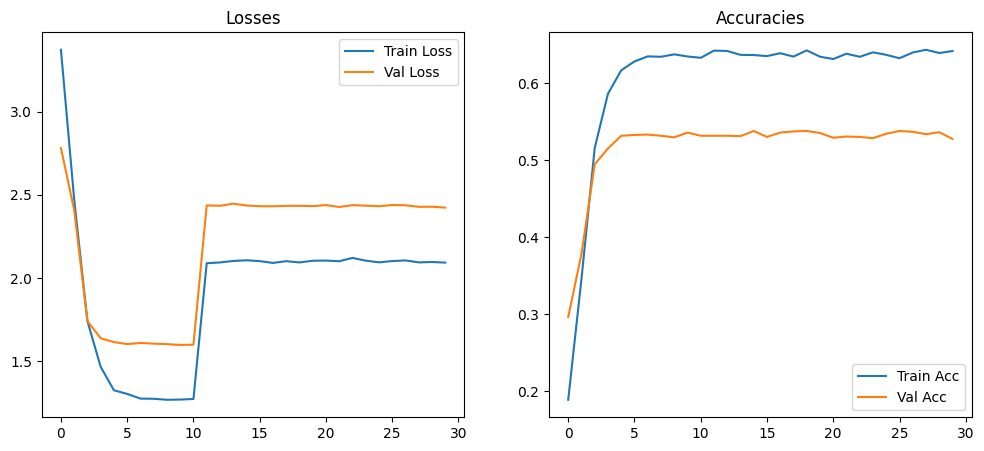

In [ ]:
#Пайплайн
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

### Добавим апскейлинг (nearest neighbor)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 109MB/s] 
100%|██████████| 237/237 [00:39<00:00,  6.06it/s]


Epoch 1/30 | Train Loss: 3.5112 | Train Acc: 0.1643 | Val Loss: 3.4582 | Val Acc: 0.1563
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.37it/s]


Epoch 2/30 | Train Loss: 2.5981 | Train Acc: 0.3139 | Val Loss: 3.2756 | Val Acc: 0.2224
Best model saved.


100%|██████████| 237/237 [00:40<00:00,  5.81it/s]


Epoch 3/30 | Train Loss: 1.8393 | Train Acc: 0.4921 | Val Loss: 3.1145 | Val Acc: 0.2482
Best model saved.


100%|██████████| 237/237 [00:38<00:00,  6.11it/s]


Epoch 4/30 | Train Loss: 1.5984 | Train Acc: 0.5436 | Val Loss: 2.9051 | Val Acc: 0.2771
Best model saved.


100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Epoch 5/30 | Train Loss: 1.4481 | Train Acc: 0.5884 | Val Loss: 2.8869 | Val Acc: 0.2848
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.32it/s]


Epoch 6/30 | Train Loss: 1.4186 | Train Acc: 0.5980 | Val Loss: 2.7812 | Val Acc: 0.2895
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.34it/s]


Epoch 7/30 | Train Loss: 1.3919 | Train Acc: 0.6068 | Val Loss: 2.8984 | Val Acc: 0.2792


100%|██████████| 237/237 [00:39<00:00,  6.05it/s]


Epoch 8/30 | Train Loss: 1.3931 | Train Acc: 0.6076 | Val Loss: 2.8197 | Val Acc: 0.2864


100%|██████████| 237/237 [00:39<00:00,  6.07it/s]


Epoch 9/30 | Train Loss: 1.3920 | Train Acc: 0.6088 | Val Loss: 2.8711 | Val Acc: 0.2797


100%|██████████| 237/237 [00:35<00:00,  6.64it/s]


Epoch 10/30 | Train Loss: 1.3979 | Train Acc: 0.6050 | Val Loss: 2.8179 | Val Acc: 0.2853


100%|██████████| 237/237 [00:36<00:00,  6.51it/s]


Epoch 11/30 | Train Loss: 1.3850 | Train Acc: 0.6104 | Val Loss: 2.8970 | Val Acc: 0.2833
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Epoch 12/30 | Train Loss: 2.1983 | Train Acc: 0.6057 | Val Loss: 3.3257 | Val Acc: 0.2812


100%|██████████| 237/237 [00:36<00:00,  6.56it/s]


Epoch 13/30 | Train Loss: 2.2004 | Train Acc: 0.6082 | Val Loss: 3.2550 | Val Acc: 0.2936
Best model saved.


100%|██████████| 237/237 [00:36<00:00,  6.45it/s]


Epoch 14/30 | Train Loss: 2.1987 | Train Acc: 0.6053 | Val Loss: 3.2574 | Val Acc: 0.2874


100%|██████████| 237/237 [00:36<00:00,  6.53it/s]


Epoch 15/30 | Train Loss: 2.1804 | Train Acc: 0.6127 | Val Loss: 3.2145 | Val Acc: 0.2957
Best model saved.


100%|██████████| 237/237 [00:36<00:00,  6.51it/s]


Epoch 16/30 | Train Loss: 2.1934 | Train Acc: 0.6076 | Val Loss: 3.3142 | Val Acc: 0.2833


100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Epoch 17/30 | Train Loss: 2.1952 | Train Acc: 0.6086 | Val Loss: 3.3311 | Val Acc: 0.2771


100%|██████████| 237/237 [00:36<00:00,  6.54it/s]


Epoch 18/30 | Train Loss: 2.1929 | Train Acc: 0.6067 | Val Loss: 3.3110 | Val Acc: 0.2802


100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Epoch 19/30 | Train Loss: 2.2071 | Train Acc: 0.6012 | Val Loss: 3.2554 | Val Acc: 0.2910


100%|██████████| 237/237 [00:39<00:00,  5.96it/s]


Epoch 20/30 | Train Loss: 2.1920 | Train Acc: 0.6087 | Val Loss: 3.3421 | Val Acc: 0.2745


100%|██████████| 237/237 [00:37<00:00,  6.40it/s]


Epoch 21/30 | Train Loss: 2.1892 | Train Acc: 0.6162 | Val Loss: 3.2102 | Val Acc: 0.2951


100%|██████████| 237/237 [00:38<00:00,  6.10it/s]


Epoch 22/30 | Train Loss: 2.1898 | Train Acc: 0.6132 | Val Loss: 3.3747 | Val Acc: 0.2724
Early stopping triggered.


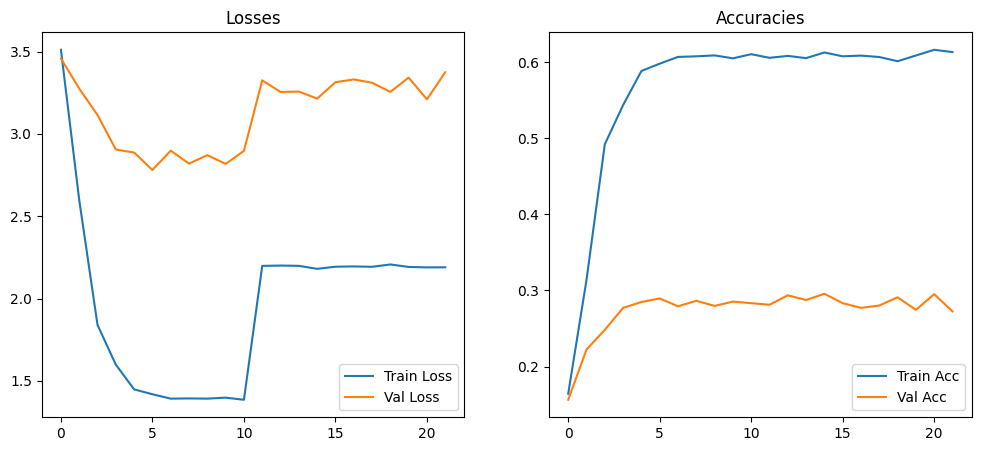

In [ ]:
#Пайплайн
transform = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_nearest_neighbor = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_nearest_neighbor.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_nearest_neighbor, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

### Добавим апскейлинг (bilinear)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 237/237 [00:40<00:00,  5.80it/s]


Epoch 1/30 | Train Loss: 3.3939 | Train Acc: 0.1912 | Val Loss: 2.7407 | Val Acc: 0.3003
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.40it/s]


Epoch 2/30 | Train Loss: 2.5028 | Train Acc: 0.3377 | Val Loss: 2.4607 | Val Acc: 0.3524
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.34it/s]


Epoch 3/30 | Train Loss: 1.7451 | Train Acc: 0.5110 | Val Loss: 1.7338 | Val Acc: 0.5093
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.35it/s]


Epoch 4/30 | Train Loss: 1.4821 | Train Acc: 0.5741 | Val Loss: 1.6631 | Val Acc: 0.5330
Best model saved.


100%|██████████| 237/237 [00:36<00:00,  6.44it/s]


Epoch 5/30 | Train Loss: 1.3328 | Train Acc: 0.6182 | Val Loss: 1.6299 | Val Acc: 0.5449
Best model saved.


100%|██████████| 237/237 [00:37<00:00,  6.39it/s]


Epoch 6/30 | Train Loss: 1.3057 | Train Acc: 0.6293 | Val Loss: 1.6136 | Val Acc: 0.5449


100%|██████████| 237/237 [00:36<00:00,  6.46it/s]


Epoch 7/30 | Train Loss: 1.2808 | Train Acc: 0.6327 | Val Loss: 1.6165 | Val Acc: 0.5387


100%|██████████| 237/237 [00:36<00:00,  6.45it/s]


Epoch 8/30 | Train Loss: 1.2864 | Train Acc: 0.6321 | Val Loss: 1.6109 | Val Acc: 0.5449


100%|██████████| 237/237 [00:36<00:00,  6.41it/s]


Epoch 9/30 | Train Loss: 1.2759 | Train Acc: 0.6339 | Val Loss: 1.6113 | Val Acc: 0.5454
Best model saved.


100%|██████████| 237/237 [00:36<00:00,  6.46it/s]


Epoch 10/30 | Train Loss: 1.2858 | Train Acc: 0.6286 | Val Loss: 1.6076 | Val Acc: 0.5413


100%|██████████| 237/237 [00:36<00:00,  6.47it/s]


Epoch 11/30 | Train Loss: 1.2951 | Train Acc: 0.6306 | Val Loss: 1.6089 | Val Acc: 0.5413
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:39<00:00,  5.95it/s]


Epoch 12/30 | Train Loss: 2.0974 | Train Acc: 0.6371 | Val Loss: 2.4606 | Val Acc: 0.5433


100%|██████████| 237/237 [00:36<00:00,  6.41it/s]


Epoch 13/30 | Train Loss: 2.1051 | Train Acc: 0.6285 | Val Loss: 2.4521 | Val Acc: 0.5454


100%|██████████| 237/237 [00:36<00:00,  6.45it/s]


Epoch 14/30 | Train Loss: 2.1061 | Train Acc: 0.6366 | Val Loss: 2.4489 | Val Acc: 0.5413


100%|██████████| 237/237 [00:36<00:00,  6.44it/s]


Epoch 15/30 | Train Loss: 2.1053 | Train Acc: 0.6280 | Val Loss: 2.4538 | Val Acc: 0.5423


100%|██████████| 237/237 [00:36<00:00,  6.45it/s]


Epoch 16/30 | Train Loss: 2.1046 | Train Acc: 0.6294 | Val Loss: 2.4546 | Val Acc: 0.5444


100%|██████████| 237/237 [00:38<00:00,  6.13it/s]


Epoch 17/30 | Train Loss: 2.1019 | Train Acc: 0.6364 | Val Loss: 2.4491 | Val Acc: 0.5449


100%|██████████| 237/237 [00:38<00:00,  6.20it/s]


Epoch 18/30 | Train Loss: 2.1037 | Train Acc: 0.6282 | Val Loss: 2.4579 | Val Acc: 0.5413


100%|██████████| 237/237 [00:38<00:00,  6.18it/s]


Epoch 19/30 | Train Loss: 2.0963 | Train Acc: 0.6384 | Val Loss: 2.4407 | Val Acc: 0.5408


100%|██████████| 237/237 [00:39<00:00,  6.07it/s]


Epoch 20/30 | Train Loss: 2.0944 | Train Acc: 0.6356 | Val Loss: 2.4424 | Val Acc: 0.5413
Early stopping triggered.


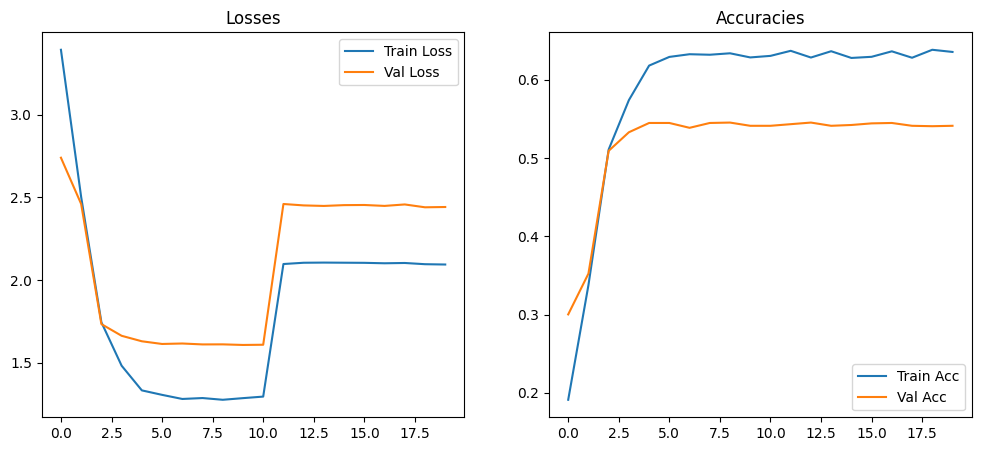

In [ ]:
#Пайплайн
transform = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_bilinear = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_bilinear.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_bilinear, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

### Добавим апскейлинг (biquadratic)

100%|██████████| 237/237 [00:36<00:00,  6.55it/s]


Epoch 1/30 | Train Loss: 3.5105 | Train Acc: 0.1673 | Val Loss: 3.6131 | Val Acc: 0.1424
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.69it/s]


Epoch 2/30 | Train Loss: 2.6133 | Train Acc: 0.3106 | Val Loss: 3.0728 | Val Acc: 0.2482
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.68it/s]


Epoch 3/30 | Train Loss: 1.8351 | Train Acc: 0.4915 | Val Loss: 2.6922 | Val Acc: 0.3256
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.68it/s]


Epoch 4/30 | Train Loss: 1.5910 | Train Acc: 0.5482 | Val Loss: 2.6833 | Val Acc: 0.3271
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.70it/s]


Epoch 5/30 | Train Loss: 1.4136 | Train Acc: 0.5931 | Val Loss: 2.6689 | Val Acc: 0.3256


100%|██████████| 237/237 [00:35<00:00,  6.68it/s]


Epoch 6/30 | Train Loss: 1.4020 | Train Acc: 0.5998 | Val Loss: 2.5858 | Val Acc: 0.3359
Best model saved.


100%|██████████| 237/237 [00:35<00:00,  6.67it/s]


Epoch 7/30 | Train Loss: 1.3735 | Train Acc: 0.6082 | Val Loss: 2.6041 | Val Acc: 0.3338


100%|██████████| 237/237 [00:38<00:00,  6.08it/s]


Epoch 8/30 | Train Loss: 1.3674 | Train Acc: 0.6116 | Val Loss: 2.5997 | Val Acc: 0.3333


100%|██████████| 237/237 [00:37<00:00,  6.26it/s]


Epoch 9/30 | Train Loss: 1.3735 | Train Acc: 0.6020 | Val Loss: 2.6822 | Val Acc: 0.3251


100%|██████████| 237/237 [00:35<00:00,  6.61it/s]


Epoch 10/30 | Train Loss: 1.3768 | Train Acc: 0.6035 | Val Loss: 2.6683 | Val Acc: 0.3282


100%|██████████| 237/237 [00:36<00:00,  6.47it/s]


Epoch 11/30 | Train Loss: 1.3673 | Train Acc: 0.6041 | Val Loss: 2.7066 | Val Acc: 0.3194
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:35<00:00,  6.66it/s]


Epoch 12/30 | Train Loss: 2.2240 | Train Acc: 0.6087 | Val Loss: 3.2823 | Val Acc: 0.3189


100%|██████████| 237/237 [00:35<00:00,  6.66it/s]


Epoch 13/30 | Train Loss: 2.2249 | Train Acc: 0.6009 | Val Loss: 3.2756 | Val Acc: 0.3179
Early stopping triggered.


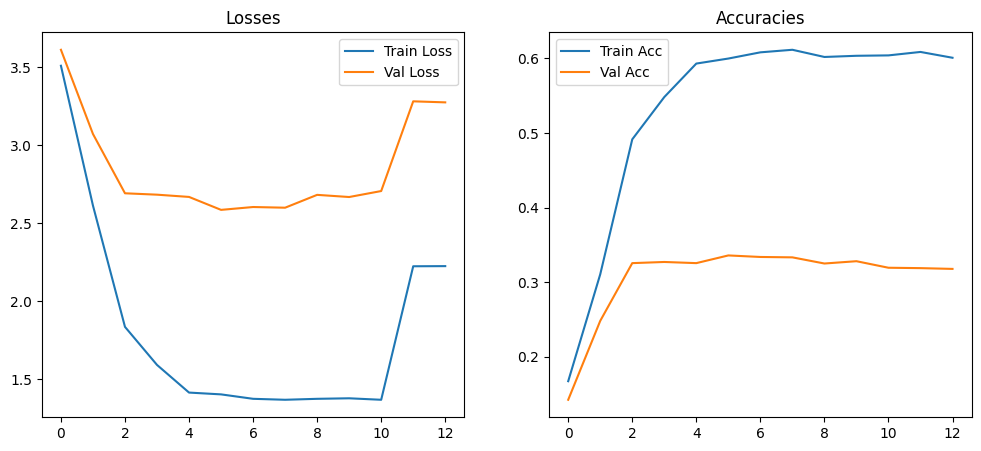

In [ ]:
#Пайплайн
transform = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_AREA),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_biquadratic = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_biquadratic.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_biquadratic, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

### Добавим апскейлинг (biсubic)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 237/237 [00:39<00:00,  6.02it/s]


Epoch 1/30 | Train Loss: 3.4510 | Train Acc: 0.1696 | Val Loss: 3.6905 | Val Acc: 0.2105
Best model saved.


100%|██████████| 237/237 [00:38<00:00,  6.09it/s]


Epoch 2/30 | Train Loss: 2.5584 | Train Acc: 0.3274 | Val Loss: 3.0049 | Val Acc: 0.2766
Best model saved.


100%|██████████| 237/237 [00:38<00:00,  6.13it/s]


Epoch 3/30 | Train Loss: 1.7847 | Train Acc: 0.4955 | Val Loss: 2.2653 | Val Acc: 0.4102
Best model saved.


100%|██████████| 237/237 [00:38<00:00,  6.14it/s]


Epoch 4/30 | Train Loss: 1.5181 | Train Acc: 0.5670 | Val Loss: 2.1393 | Val Acc: 0.4360
Best model saved.


100%|██████████| 237/237 [00:38<00:00,  6.16it/s]


Epoch 5/30 | Train Loss: 1.3498 | Train Acc: 0.6050 | Val Loss: 2.0538 | Val Acc: 0.4479
Best model saved.


100%|██████████| 237/237 [00:38<00:00,  6.14it/s]


Epoch 6/30 | Train Loss: 1.3243 | Train Acc: 0.6220 | Val Loss: 2.2101 | Val Acc: 0.4252


100%|██████████| 237/237 [00:39<00:00,  6.01it/s]


Epoch 7/30 | Train Loss: 1.2994 | Train Acc: 0.6226 | Val Loss: 2.1807 | Val Acc: 0.4278


100%|██████████| 237/237 [00:38<00:00,  6.10it/s]


Epoch 8/30 | Train Loss: 1.3147 | Train Acc: 0.6190 | Val Loss: 2.2038 | Val Acc: 0.4267


100%|██████████| 237/237 [00:38<00:00,  6.14it/s]


Epoch 9/30 | Train Loss: 1.3006 | Train Acc: 0.6233 | Val Loss: 2.0839 | Val Acc: 0.4469


100%|██████████| 237/237 [00:40<00:00,  5.84it/s]


Epoch 10/30 | Train Loss: 1.2862 | Train Acc: 0.6257 | Val Loss: 2.1461 | Val Acc: 0.4329


100%|██████████| 237/237 [00:39<00:00,  5.96it/s]


Epoch 11/30 | Train Loss: 1.3024 | Train Acc: 0.6218 | Val Loss: 2.1411 | Val Acc: 0.4370
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:38<00:00,  6.14it/s]


Epoch 12/30 | Train Loss: 2.1765 | Train Acc: 0.6208 | Val Loss: 2.8912 | Val Acc: 0.4314
Early stopping triggered.


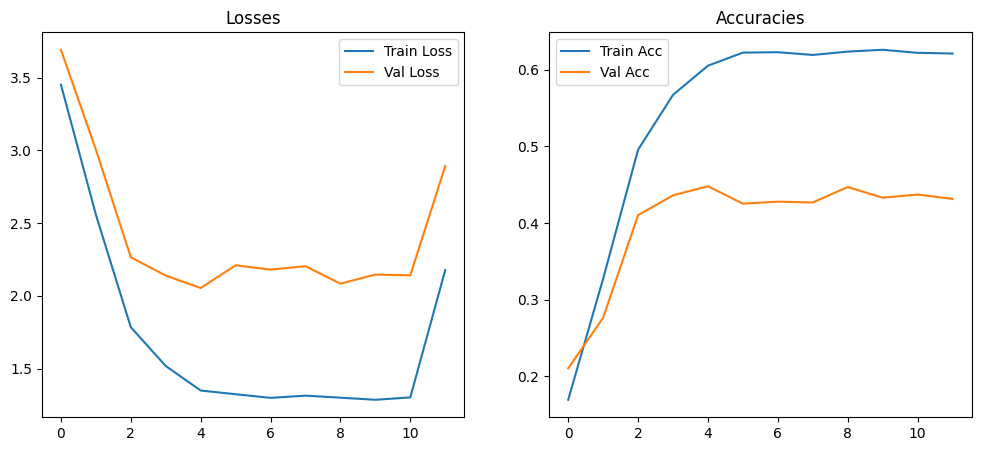

In [ ]:
#Пайплайн
transform = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_CUBIC),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_biсubic = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_biсubic.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_biсubic, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

In [ ]:
val_accuracies_biсubic = [0.21052631578947367,
 0.27657378740970073,
 0.4102167182662539,
 0.4360165118679051,
 0.44788441692466463,
 0.42518059855521156,
 0.4277605779153767,
 0.42672858617131065,
 0.44685242518059853,
 0.4329205366357069,
 0.4370485036119711,
 0.43137254901960786]

In [ ]:
val_accuracies_biquadratic = [0.14241486068111456,
 0.24819401444788441,
 0.325593395252838,
 0.32714138286893707,
 0.325593395252838,
 0.33591331269349844,
 0.33384932920536636,
 0.3333333333333333,
 0.32507739938080493,
 0.3281733746130031,
 0.3194014447884417,
 0.3188854489164087,
 0.31785345717234265]

In [ ]:
val_accuracies_bilinear = [0.30030959752321984,
 0.3524251805985552,
 0.5092879256965944,
 0.5330237358101135,
 0.544891640866873,
 0.544891640866873,
 0.5386996904024768,
 0.544891640866873,
 0.5454076367389061,
 0.5412796697626419,
 0.5412796697626419,
 0.5433436532507739,
 0.5454076367389061,
 0.5412796697626419,
 0.542311661506708,
 0.54437564499484,
 0.544891640866873,
 0.5412796697626419,
 0.5407636738906089,
 0.5412796697626419]

In [ ]:
val_accuracies_nearest_neighbor = [0.1563467492260062, 0.22239422084623323, 0.24819401444788441, 0.2770897832817337,
 0.2848297213622291, 0.2894736842105263, 0.27915376676986586, 0.28637770897832815, 0.27966976264189886, 0.2853457172342621,
 0.28328173374613, 0.28121775025799794, 0.2936016511867905, 0.28740970072239425, 0.29566563467492263, 0.28328173374613,
 0.2770897832817337, 0.2801857585139319, 0.29102167182662536, 0.27450980392156865, 0.2951496388028896, 0.2724458204334365]

In [ ]:
val_accuracies = [0.2961816305469556, 0.3782249742002064, 0.49484004127966974, 0.5154798761609907, 0.5319917440660474,
 0.5330237358101135, 0.5335397316821465, 0.5319917440660474, 0.5299277605779154, 0.5361197110423117, 0.5319917440660474,
 0.5319917440660474, 0.5319917440660474, 0.5314757481940144, 0.5381836945304438, 0.5304437564499485, 0.536119711042317,
 0.5376676986584107, 0.5381836945304438, 0.5356037151702786, 0.5294117647058824, 0.5309597523219814, 0.5304437564499485,
 0.5288957688338494, 0.5345717234262126, 0.5381836945304438, 0.5371517027863777, 0.5340557275541795, 0.5366357069143447,
 0.5278637770897833]

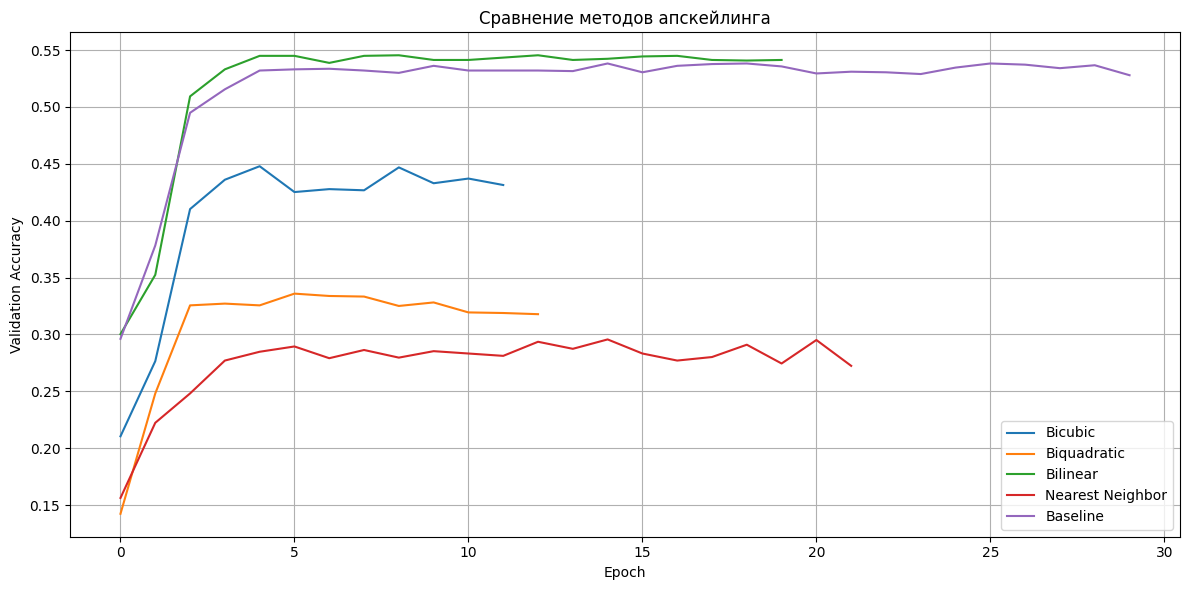

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(val_accuracies_biсubic, label='Bicubic')
plt.plot(val_accuracies_biquadratic, label='Biquadratic')
plt.plot(val_accuracies_bilinear, label='Bilinear')
plt.plot(val_accuracies_nearest_neighbor, label='Nearest Neighbor')
plt.plot(val_accuracies, label='Baseline')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Сравнение методов апскейлинга')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Модель с transfer learning(mobilenet_v2) с навороченными аугментациями

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-31-8c16969fd6c4>:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
<ipython-input-31-8c16969fd6c4>:27: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=2, max_height=8, max_width=8, p=0.5),
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed 

Epoch 1/30 | Train Loss: 4.2650 | Train Acc: 0.0539 | Val Loss: 3.7716 | Val Acc: 0.1146
Best model saved.


100%|██████████| 237/237 [00:40<00:00,  5.85it/s]


Epoch 2/30 | Train Loss: 3.8175 | Train Acc: 0.0996 | Val Loss: 3.4017 | Val Acc: 0.1703
Best model saved.


100%|██████████| 237/237 [00:43<00:00,  5.41it/s]


Epoch 3/30 | Train Loss: 3.2733 | Train Acc: 0.1891 | Val Loss: 2.7761 | Val Acc: 0.2817
Best model saved.


100%|██████████| 237/237 [00:43<00:00,  5.47it/s]


Epoch 4/30 | Train Loss: 3.0864 | Train Acc: 0.2244 | Val Loss: 2.6512 | Val Acc: 0.3039
Best model saved.


100%|██████████| 237/237 [00:43<00:00,  5.40it/s]


Epoch 5/30 | Train Loss: 2.9660 | Train Acc: 0.2550 | Val Loss: 2.6017 | Val Acc: 0.3168
Best model saved.


100%|██████████| 237/237 [00:46<00:00,  5.15it/s]


Epoch 6/30 | Train Loss: 2.9030 | Train Acc: 0.2624 | Val Loss: 2.5597 | Val Acc: 0.3199
Best model saved.


100%|██████████| 237/237 [00:39<00:00,  5.97it/s]


Epoch 7/30 | Train Loss: 2.9104 | Train Acc: 0.2635 | Val Loss: 2.5495 | Val Acc: 0.3158


100%|██████████| 237/237 [00:39<00:00,  6.00it/s]


Epoch 8/30 | Train Loss: 2.9184 | Train Acc: 0.2645 | Val Loss: 2.5629 | Val Acc: 0.3194


100%|██████████| 237/237 [00:39<00:00,  5.94it/s]


Epoch 9/30 | Train Loss: 2.9002 | Train Acc: 0.2596 | Val Loss: 2.5602 | Val Acc: 0.3199


100%|██████████| 237/237 [00:39<00:00,  5.99it/s]


Epoch 10/30 | Train Loss: 2.8823 | Train Acc: 0.2618 | Val Loss: 2.5250 | Val Acc: 0.3251
Best model saved.


100%|██████████| 237/237 [00:40<00:00,  5.87it/s]


Epoch 11/30 | Train Loss: 2.8862 | Train Acc: 0.2709 | Val Loss: 2.5691 | Val Acc: 0.3163
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:39<00:00,  5.99it/s]


Epoch 12/30 | Train Loss: 3.3022 | Train Acc: 0.2660 | Val Loss: 3.1571 | Val Acc: 0.3220


100%|██████████| 237/237 [00:39<00:00,  5.96it/s]


Epoch 13/30 | Train Loss: 3.3130 | Train Acc: 0.2706 | Val Loss: 3.1400 | Val Acc: 0.3225


100%|██████████| 237/237 [00:39<00:00,  5.97it/s]


Epoch 14/30 | Train Loss: 3.3129 | Train Acc: 0.2610 | Val Loss: 3.1374 | Val Acc: 0.3235


100%|██████████| 237/237 [00:39<00:00,  6.00it/s]


Epoch 15/30 | Train Loss: 3.3049 | Train Acc: 0.2697 | Val Loss: 3.1638 | Val Acc: 0.3209


100%|██████████| 237/237 [00:39<00:00,  5.95it/s]


Epoch 16/30 | Train Loss: 3.3302 | Train Acc: 0.2618 | Val Loss: 3.1668 | Val Acc: 0.3230


100%|██████████| 237/237 [00:39<00:00,  5.98it/s]


Epoch 17/30 | Train Loss: 3.3150 | Train Acc: 0.2641 | Val Loss: 3.1145 | Val Acc: 0.3235
Early stopping triggered.


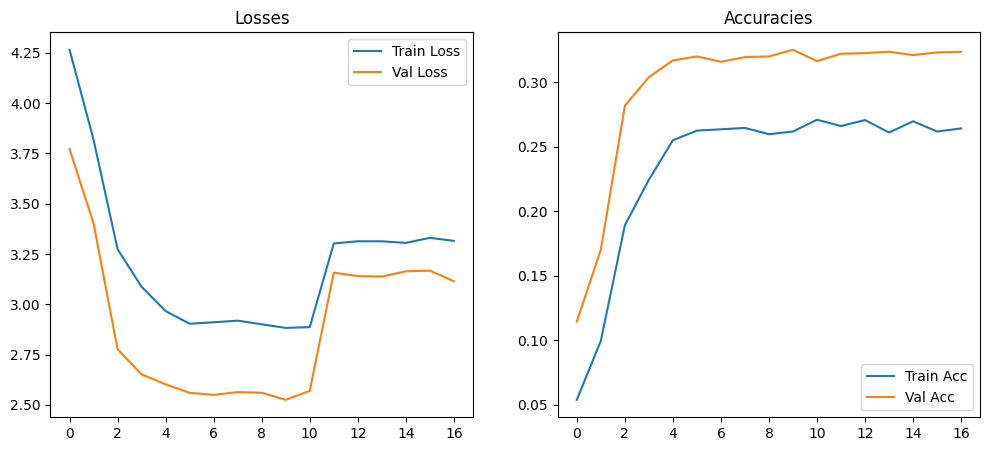

In [ ]:
#Пайплайн
transform = A.Compose([
    A.OneOf([
        A.PadIfNeeded(min_height=36, min_width=36, border_mode=0),
        A.Resize(height=36, width=36),
        A.RandomCrop(height=32, width=32)
    ], p=1.0),

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25, border_mode=1, p=0.5),

    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RGBShift(p=0.5),
        A.CLAHE(p=0.3)
    ], p=0.7),

    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
        A.Blur(blur_limit=3, p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3),
    ], p=0.5),

    A.CoarseDropout(max_holes=2, max_height=8, max_width=8, p=0.5),
    A.Resize(height=224, width=224),

    A.Normalize(mean=(0.5071, 0.4865, 0.4409), std=(0.2673, 0.2564, 0.2762)),
    ToTensorV2()
])

# Трансформации для тестового набора
test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_1 = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_1.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_1, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

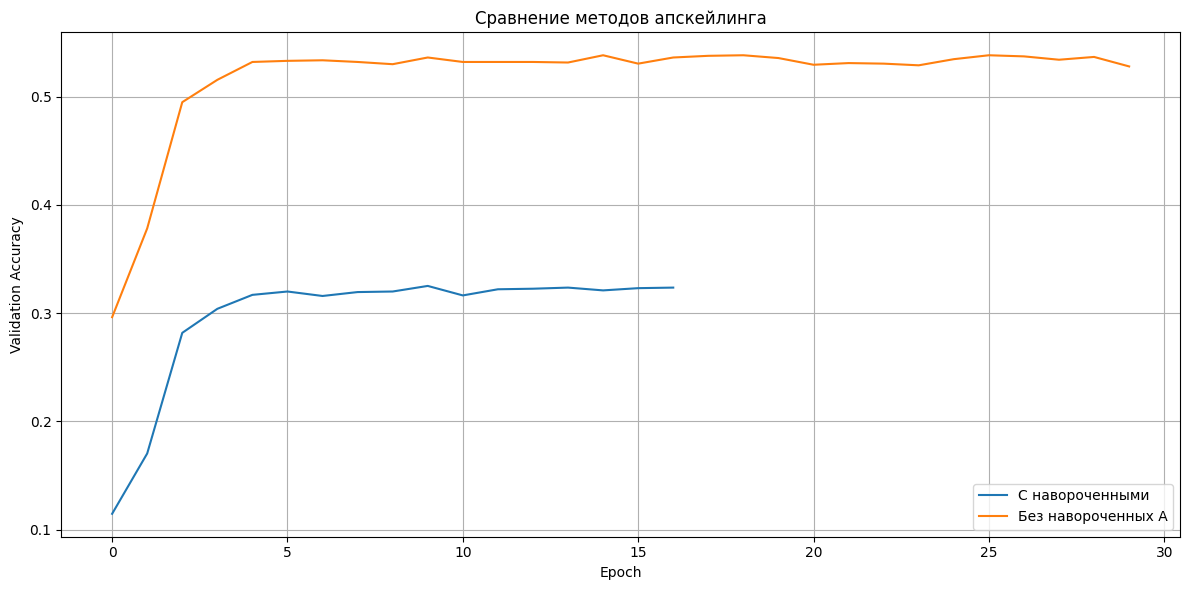

In [ ]:
val_accuracies = [0.2961816305469556, 0.3782249742002064, 0.49484004127966974, 0.5154798761609907, 0.5319917440660474, 0.5330237358101135,
 0.5335397316821465, 0.5319917440660474, 0.5299277605779154, 0.5361197110423117, 0.5319917440660474, 0.5319917440660474, 0.5319917440660474,
 0.5314757481940144, 0.5381836945304438, 0.5304437564499485, 0.536119711042317, 0.5376676986584107, 0.5381836945304438, 0.5356037151702786,
 0.5294117647058824, 0.5309597523219814, 0.5304437564499485, 0.5288957688338494, 0.5345717234262126, 0.5381836945304438, 0.5371517027863777,
 0.5340557275541795, 0.5366357069143447, 0.5278637770897833]
val_accuracies_1 = [0.11455108359133127, 0.17027863777089783, 0.28173374613003094, 0.30392156862745096, 0.31682146542827655, 0.31991744066047473,
 0.3157894736842105, 0.3194014447884417, 0.31991744066047473, 0.32507739938080493, 0.31630546955624356, 0.3219814241486068, 0.32249742002063986,
 0.3235294117647059, 0.32094943240454077, 0.32301341589267285, 0.3235294117647059]

plt.figure(figsize=(12, 6))

plt.plot(val_accuracies_1, label='С навороченными')
plt.plot(val_accuracies, label='Без навороченных А')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Сравнение методов апскейлинга')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## SimpleCNN

#### Модель без transfer learning и навороченных аугментаций

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)  # -> 112×112

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)  # -> 56×56

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)  # -> 28×28

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(2, 2)  # -> 14×14

        self.fc1 = nn.Linear(128 * 14 * 14, 256)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x

100%|██████████| 237/237 [00:21<00:00, 11.03it/s]


Epoch 1/30 | Train Loss: 4.3497 | Train Acc: 0.0536 | Val Loss: 4.1422 | Val Acc: 0.0831
Best model saved.


100%|██████████| 237/237 [00:16<00:00, 14.59it/s]


Epoch 2/30 | Train Loss: 3.9325 | Train Acc: 0.1096 | Val Loss: 3.8770 | Val Acc: 0.1120
Best model saved.


100%|██████████| 237/237 [00:13<00:00, 16.97it/s]


Epoch 3/30 | Train Loss: 3.6901 | Train Acc: 0.1459 | Val Loss: 3.7856 | Val Acc: 0.1300
Best model saved.


100%|██████████| 237/237 [00:13<00:00, 17.06it/s]


Epoch 4/30 | Train Loss: 3.6280 | Train Acc: 0.1582 | Val Loss: 3.7643 | Val Acc: 0.1347
Best model saved.


100%|██████████| 237/237 [00:13<00:00, 17.04it/s]


Epoch 5/30 | Train Loss: 3.5961 | Train Acc: 0.1648 | Val Loss: 3.7592 | Val Acc: 0.1347


100%|██████████| 237/237 [00:13<00:00, 17.15it/s]


Epoch 6/30 | Train Loss: 3.5858 | Train Acc: 0.1669 | Val Loss: 3.7568 | Val Acc: 0.1336


100%|██████████| 237/237 [00:13<00:00, 16.98it/s]


Epoch 7/30 | Train Loss: 3.5870 | Train Acc: 0.1663 | Val Loss: 3.7566 | Val Acc: 0.1326


100%|██████████| 237/237 [00:13<00:00, 17.17it/s]


Epoch 8/30 | Train Loss: 3.5848 | Train Acc: 0.1643 | Val Loss: 3.7564 | Val Acc: 0.1326


100%|██████████| 237/237 [00:14<00:00, 16.75it/s]


Epoch 9/30 | Train Loss: 3.5851 | Train Acc: 0.1652 | Val Loss: 3.7564 | Val Acc: 0.1326


100%|██████████| 237/237 [00:13<00:00, 17.03it/s]


Epoch 10/30 | Train Loss: 3.5832 | Train Acc: 0.1630 | Val Loss: 3.7564 | Val Acc: 0.1326


100%|██████████| 237/237 [00:13<00:00, 17.13it/s]


Epoch 11/30 | Train Loss: 3.5864 | Train Acc: 0.1619 | Val Loss: 3.7564 | Val Acc: 0.1326
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:14<00:00, 16.48it/s]


Epoch 12/30 | Train Loss: 3.8092 | Train Acc: 0.1640 | Val Loss: 3.9613 | Val Acc: 0.1326
Early stopping triggered.


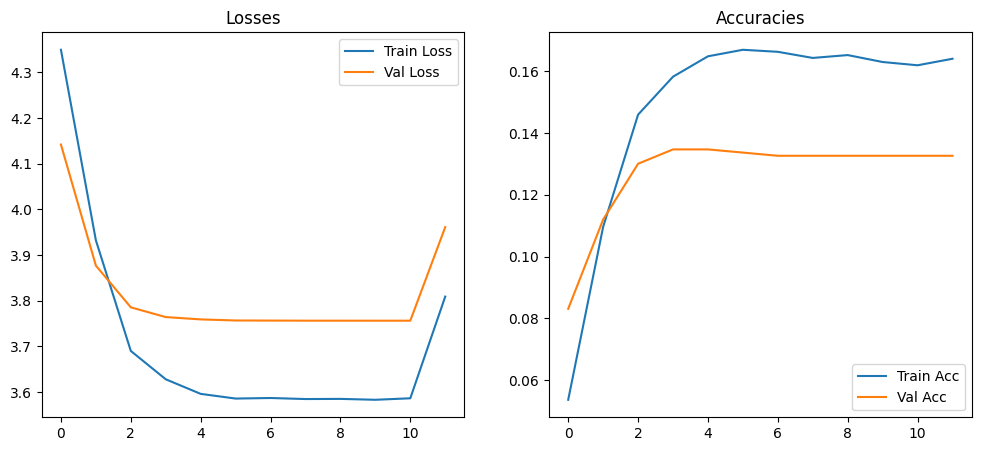

In [12]:
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])


# Трансформации для тестового набора
test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = SimpleCNN(num_classes).to(device)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_s = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_s.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_s, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

#### Модель без transfer learning c навороченными аугментациями

100%|██████████| 237/237 [00:19<00:00, 12.45it/s]


Epoch 1/30 | Train Loss: 4.4884 | Train Acc: 0.0317 | Val Loss: 4.2634 | Val Acc: 0.0645
Best model saved.


100%|██████████| 237/237 [00:18<00:00, 12.70it/s]


Epoch 2/30 | Train Loss: 4.1693 | Train Acc: 0.0722 | Val Loss: 3.9856 | Val Acc: 0.1053
Best model saved.


100%|██████████| 237/237 [00:18<00:00, 12.56it/s]


Epoch 3/30 | Train Loss: 3.9865 | Train Acc: 0.0965 | Val Loss: 3.8933 | Val Acc: 0.1285
Best model saved.


100%|██████████| 237/237 [00:18<00:00, 12.72it/s]


Epoch 4/30 | Train Loss: 3.9547 | Train Acc: 0.1067 | Val Loss: 3.8553 | Val Acc: 0.1295
Best model saved.


100%|██████████| 237/237 [00:18<00:00, 12.59it/s]


Epoch 5/30 | Train Loss: 3.9212 | Train Acc: 0.1144 | Val Loss: 3.8525 | Val Acc: 0.1305
Best model saved.


100%|██████████| 237/237 [00:18<00:00, 12.63it/s]


Epoch 6/30 | Train Loss: 3.9107 | Train Acc: 0.1153 | Val Loss: 3.8494 | Val Acc: 0.1311
Best model saved.


100%|██████████| 237/237 [00:18<00:00, 12.48it/s]


Epoch 7/30 | Train Loss: 3.9156 | Train Acc: 0.1133 | Val Loss: 3.8492 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.10it/s]


Epoch 8/30 | Train Loss: 3.9210 | Train Acc: 0.1084 | Val Loss: 3.8490 | Val Acc: 0.1311


100%|██████████| 237/237 [00:18<00:00, 12.58it/s]


Epoch 9/30 | Train Loss: 3.9101 | Train Acc: 0.1115 | Val Loss: 3.8490 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.46it/s]


Epoch 10/30 | Train Loss: 3.9136 | Train Acc: 0.1145 | Val Loss: 3.8490 | Val Acc: 0.1311


 43%|████▎     | 102/237 [00:08<00:10, 12.76it/s]

Epoch 14/30 | Train Loss: 4.0702 | Train Acc: 0.1116 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.39it/s]


Epoch 15/30 | Train Loss: 4.0717 | Train Acc: 0.1104 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.38it/s]


Epoch 16/30 | Train Loss: 4.0623 | Train Acc: 0.1161 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.43it/s]


Epoch 17/30 | Train Loss: 4.0664 | Train Acc: 0.1150 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.40it/s]


Epoch 18/30 | Train Loss: 4.0659 | Train Acc: 0.1142 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:18<00:00, 12.48it/s]


Epoch 19/30 | Train Loss: 4.0623 | Train Acc: 0.1129 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.43it/s]


Epoch 20/30 | Train Loss: 4.0672 | Train Acc: 0.1141 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:18<00:00, 12.51it/s]


Epoch 21/30 | Train Loss: 4.0721 | Train Acc: 0.1154 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:18<00:00, 12.48it/s]


Epoch 22/30 | Train Loss: 4.0656 | Train Acc: 0.1138 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.42it/s]


Epoch 23/30 | Train Loss: 4.0692 | Train Acc: 0.1129 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.46it/s]


Epoch 24/30 | Train Loss: 4.0667 | Train Acc: 0.1124 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.19it/s]


Epoch 25/30 | Train Loss: 4.0711 | Train Acc: 0.1101 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.26it/s]


Epoch 26/30 | Train Loss: 4.0705 | Train Acc: 0.1078 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.11it/s]


Epoch 27/30 | Train Loss: 4.0713 | Train Acc: 0.1117 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.15it/s]


Epoch 28/30 | Train Loss: 4.0652 | Train Acc: 0.1134 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:18<00:00, 12.50it/s]


Epoch 29/30 | Train Loss: 4.0691 | Train Acc: 0.1120 | Val Loss: 4.0169 | Val Acc: 0.1311


100%|██████████| 237/237 [00:19<00:00, 12.46it/s]


Epoch 30/30 | Train Loss: 4.0617 | Train Acc: 0.1111 | Val Loss: 4.0169 | Val Acc: 0.1311


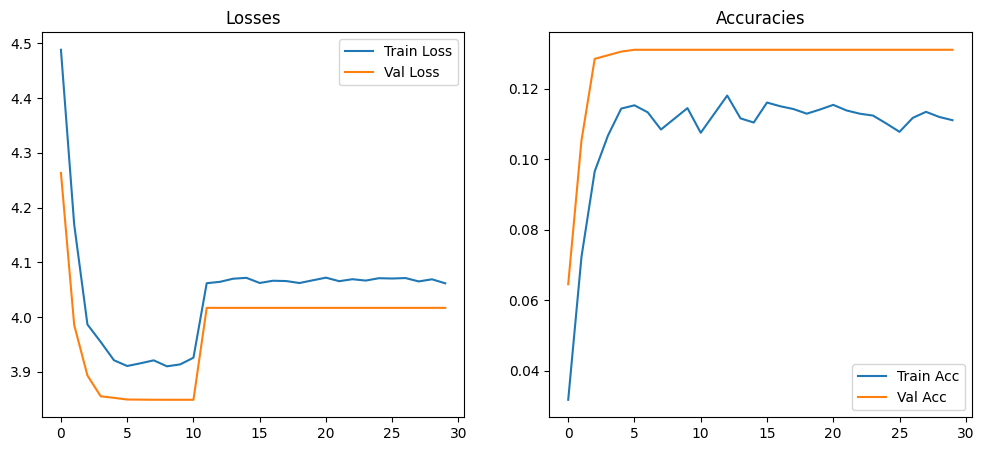

In [ ]:
transform = A.Compose([
    A.OneOf([
        A.PadIfNeeded(min_height=36, min_width=36, border_mode=0),
        A.Resize(height=36, width=36),
        A.RandomCrop(height=32, width=32)
    ], p=1.0),

    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=25, border_mode=1, p=0.5),

    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RGBShift(p=0.5),
        A.CLAHE(p=0.3)
    ], p=0.7),

    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.4),
        A.Blur(blur_limit=3, p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3),
    ], p=0.5),

    A.CoarseDropout(max_holes=2, max_height=8, max_width=8, p=0.5),
    A.Resize(height=224, width=224),

    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2()
])


# Трансформации для тестового набора
test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = SimpleCNN(num_classes).to(device)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_s2 = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_s2.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_s2, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

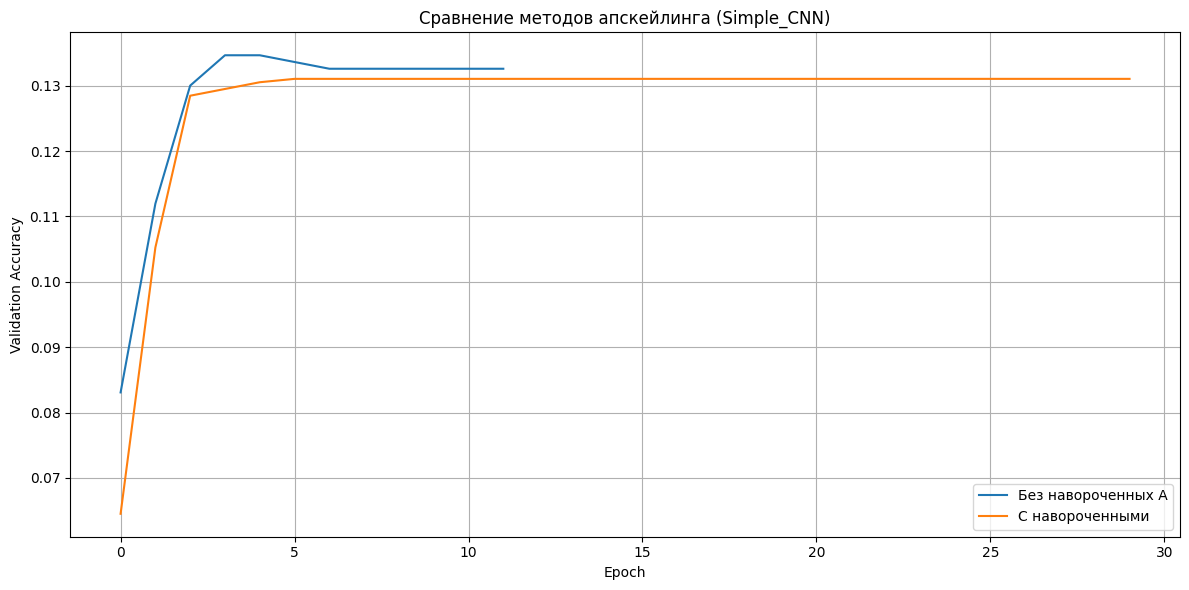

In [18]:
val_accuracies_s = [0.08307533539731682, 0.11197110423116616, 0.13003095975232198, 0.1346749226006192,
 0.1346749226006192, 0.13364293085655315, 0.13261093911248711, 0.13261093911248711, 0.13261093911248711,
 0.13261093911248711, 0.13261093911248711, 0.13261093911248711]
val_accuracies_s2 = [0.06449948400412797, 0.10526315789473684, 0.12848297213622292, 0.12951496388028896,
 0.130546955624355, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802,
 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802,
 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802,
 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802,
 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802, 0.13106295149638802,
 0.13106295149638802]

plt.figure(figsize=(12, 6))

plt.plot(val_accuracies_s, label='Без навороченных А')
plt.plot(val_accuracies_s2, label='C навороченными')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Сравнение методов апскейлинга (Simple_CNN)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## AlexNet

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 237/237 [00:17<00:00, 13.70it/s]


Epoch 1/30 | Train Loss: 2.7583 | Train Acc: 0.3278 | Val Loss: 1.9849 | Val Acc: 0.4639
Best model saved.


100%|██████████| 237/237 [00:17<00:00, 13.87it/s]


Epoch 2/30 | Train Loss: 1.4565 | Train Acc: 0.5926 | Val Loss: 1.6837 | Val Acc: 0.5351
Best model saved.


100%|██████████| 237/237 [00:16<00:00, 13.94it/s]


Epoch 3/30 | Train Loss: 0.7456 | Train Acc: 0.7822 | Val Loss: 1.4900 | Val Acc: 0.5862
Best model saved.


100%|██████████| 237/237 [00:17<00:00, 13.67it/s]


Epoch 4/30 | Train Loss: 0.5971 | Train Acc: 0.8195 | Val Loss: 1.5095 | Val Acc: 0.5934
Best model saved.


100%|██████████| 237/237 [00:17<00:00, 13.92it/s]


Epoch 5/30 | Train Loss: 0.4995 | Train Acc: 0.8516 | Val Loss: 1.5027 | Val Acc: 0.5949
Best model saved.


100%|██████████| 237/237 [00:17<00:00, 13.89it/s]


Epoch 6/30 | Train Loss: 0.5004 | Train Acc: 0.8539 | Val Loss: 1.5034 | Val Acc: 0.5934


100%|██████████| 237/237 [00:17<00:00, 13.63it/s]


Epoch 7/30 | Train Loss: 0.4786 | Train Acc: 0.8564 | Val Loss: 1.5036 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.93it/s]


Epoch 8/30 | Train Loss: 0.4777 | Train Acc: 0.8579 | Val Loss: 1.5034 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.90it/s]


Epoch 9/30 | Train Loss: 0.4701 | Train Acc: 0.8558 | Val Loss: 1.5035 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.72it/s]


Epoch 10/30 | Train Loss: 0.4661 | Train Acc: 0.8616 | Val Loss: 1.5035 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.09it/s]


Epoch 11/30 | Train Loss: 0.4837 | Train Acc: 0.8541 | Val Loss: 1.5035 | Val Acc: 0.5949
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:17<00:00, 13.86it/s]


Epoch 12/30 | Train Loss: 1.8895 | Train Acc: 0.8555 | Val Loss: 2.7041 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.16it/s]


Epoch 13/30 | Train Loss: 1.8977 | Train Acc: 0.8551 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.09it/s]


Epoch 14/30 | Train Loss: 1.8969 | Train Acc: 0.8607 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.88it/s]


Epoch 15/30 | Train Loss: 1.8931 | Train Acc: 0.8572 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.14it/s]


Epoch 16/30 | Train Loss: 1.8939 | Train Acc: 0.8578 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.85it/s]


Epoch 17/30 | Train Loss: 1.9033 | Train Acc: 0.8525 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.17it/s]


Epoch 18/30 | Train Loss: 1.8890 | Train Acc: 0.8584 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.04it/s]


Epoch 19/30 | Train Loss: 1.8899 | Train Acc: 0.8566 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.90it/s]


Epoch 20/30 | Train Loss: 1.8890 | Train Acc: 0.8542 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.08it/s]


Epoch 21/30 | Train Loss: 1.8949 | Train Acc: 0.8563 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.82it/s]


Epoch 22/30 | Train Loss: 1.8865 | Train Acc: 0.8575 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.05it/s]


Epoch 23/30 | Train Loss: 1.8905 | Train Acc: 0.8572 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 13.95it/s]


Epoch 24/30 | Train Loss: 1.8828 | Train Acc: 0.8579 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.78it/s]


Epoch 25/30 | Train Loss: 1.8999 | Train Acc: 0.8568 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.14it/s]


Epoch 26/30 | Train Loss: 1.8906 | Train Acc: 0.8567 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.81it/s]


Epoch 27/30 | Train Loss: 1.8823 | Train Acc: 0.8616 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.14it/s]


Epoch 28/30 | Train Loss: 1.8930 | Train Acc: 0.8550 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:16<00:00, 14.02it/s]


Epoch 29/30 | Train Loss: 1.8895 | Train Acc: 0.8642 | Val Loss: 2.7040 | Val Acc: 0.5949


100%|██████████| 237/237 [00:17<00:00, 13.71it/s]


Epoch 30/30 | Train Loss: 1.8946 | Train Acc: 0.8567 | Val Loss: 2.7040 | Val Acc: 0.5949


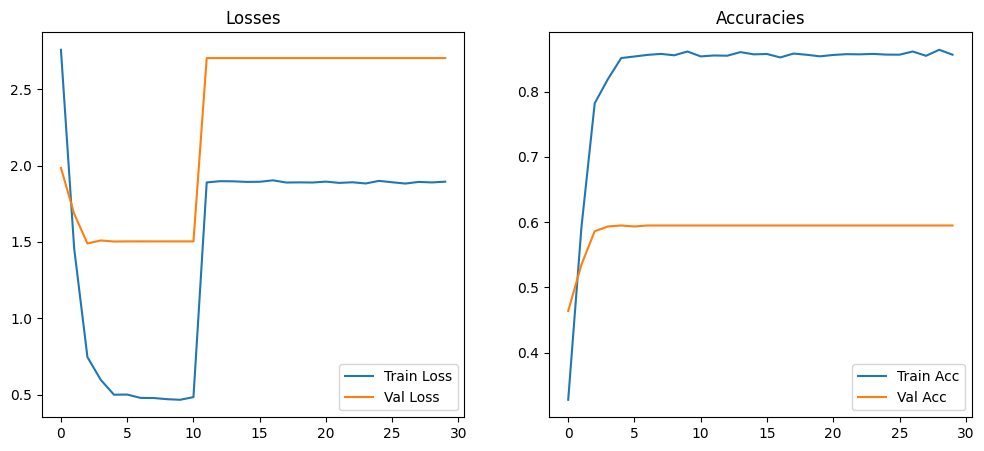

In [ ]:
# transform = A.Compose([
#     A.Resize(height=224, width=224),
#     #A.RandomCrop(width=32, height=32, p=1.0),
#     A.HorizontalFlip(p=0.5),
#     #A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
#     #A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, p=0.2),
#     A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
#     ToTensorV2(),
# ])

# test_transforms = A.Compose([
#     A.Resize(height=224, width=224),
#     A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
#     ToTensorV2(),
# ])

transform = A.Compose([
    A.Resize(height=224, width=224),  # Размер, с которым тренировалась EfficientNet_B7
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.4), # Более интенсивные преобразования
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

# Трансформации для тестового набора
test_transform = A.Compose([
    A.Resize(height=224, width=224),  # Соответствует размеру в train
    #A.CenterCrop(height=512, width=512), # CenterCrop, так как EfficientNet_B7 была обучена на изображениях размером 512x512
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_a = []

num_epochs = 10

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_a.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_a, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

## Resnet

100%|██████████| 237/237 [00:29<00:00,  8.13it/s]


Epoch 1/30 | Train Loss: 3.5653 | Train Acc: 0.1669 | Val Loss: 3.3039 | Val Acc: 0.2090
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.07it/s]


Epoch 2/30 | Train Loss: 2.6842 | Train Acc: 0.3044 | Val Loss: 2.6916 | Val Acc: 0.3235
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.12it/s]


Epoch 3/30 | Train Loss: 1.8953 | Train Acc: 0.4865 | Val Loss: 1.9200 | Val Acc: 0.4757
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.12it/s]


Epoch 4/30 | Train Loss: 1.6308 | Train Acc: 0.5531 | Val Loss: 1.8249 | Val Acc: 0.4979
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.13it/s]


Epoch 5/30 | Train Loss: 1.4787 | Train Acc: 0.6002 | Val Loss: 1.7835 | Val Acc: 0.5057
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.10it/s]


Epoch 6/30 | Train Loss: 1.4504 | Train Acc: 0.6042 | Val Loss: 1.7717 | Val Acc: 0.5119
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.14it/s]


Epoch 7/30 | Train Loss: 1.4414 | Train Acc: 0.6014 | Val Loss: 1.7712 | Val Acc: 0.5160
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.16it/s]


Epoch 8/30 | Train Loss: 1.4294 | Train Acc: 0.6144 | Val Loss: 1.7643 | Val Acc: 0.5186
Best model saved.


100%|██████████| 237/237 [00:29<00:00,  8.09it/s]


Epoch 9/30 | Train Loss: 1.4313 | Train Acc: 0.6062 | Val Loss: 1.7644 | Val Acc: 0.5155


100%|██████████| 237/237 [00:29<00:00,  8.16it/s]


Epoch 10/30 | Train Loss: 1.4329 | Train Acc: 0.6111 | Val Loss: 1.7668 | Val Acc: 0.5165


100%|██████████| 237/237 [00:29<00:00,  8.14it/s]


Epoch 11/30 | Train Loss: 1.4354 | Train Acc: 0.6112 | Val Loss: 1.7673 | Val Acc: 0.5170
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:29<00:00,  8.09it/s]


Epoch 12/30 | Train Loss: 2.1345 | Train Acc: 0.6091 | Val Loss: 2.4741 | Val Acc: 0.5165


100%|██████████| 237/237 [00:29<00:00,  8.12it/s]


Epoch 13/30 | Train Loss: 2.1389 | Train Acc: 0.6109 | Val Loss: 2.4740 | Val Acc: 0.5150


100%|██████████| 237/237 [00:29<00:00,  8.14it/s]


Epoch 14/30 | Train Loss: 2.1252 | Train Acc: 0.6119 | Val Loss: 2.4700 | Val Acc: 0.5134


100%|██████████| 237/237 [00:29<00:00,  8.11it/s]


Epoch 15/30 | Train Loss: 2.1342 | Train Acc: 0.6125 | Val Loss: 2.4676 | Val Acc: 0.5119
Early stopping triggered.


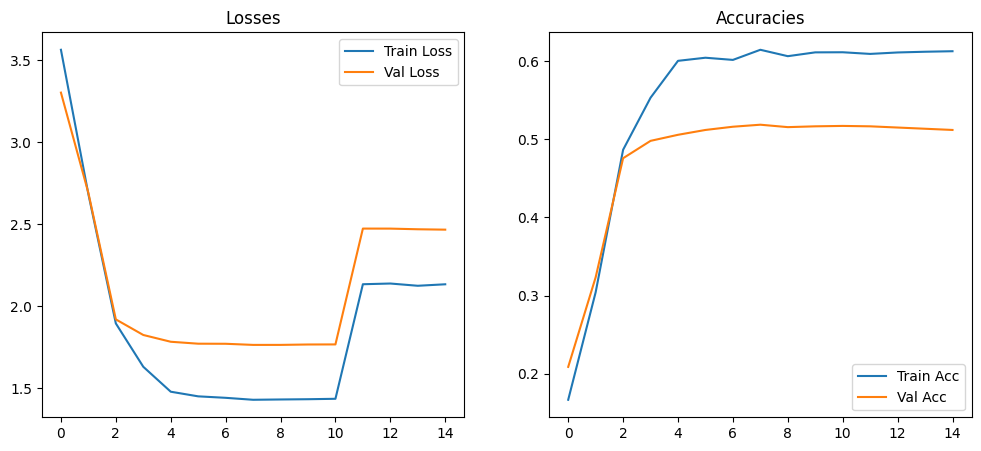

In [ ]:
#Пайплайн
# transform = A.Compose([
#     A.Resize(height=224, width=224),
#     A.RandomCrop(width=32, height=32, p=1.0),
#     A.HorizontalFlip(p=0.5),
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3),
#     A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=0, p=0.2),
#     A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
#     ToTensorV2(),
# ])

# test_transforms = A.Compose([
#     A.Resize(height=224, width=224),
#     A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
#     ToTensorV2(),
# ])
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_r = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_r.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_r, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

## efficientnet_b0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 71.4MB/s]
100%|██████████| 947/947 [00:55<00:00, 16.92it/s]


Epoch 1/30 | Train Loss: 3.5223 | Train Acc: 0.1681 | Val Loss: 2.8492 | Val Acc: 0.3117
Best model saved.


100%|██████████| 947/947 [00:59<00:00, 15.96it/s]


Epoch 2/30 | Train Loss: 2.6424 | Train Acc: 0.3230 | Val Loss: 2.4233 | Val Acc: 0.3880
Best model saved.


100%|██████████| 947/947 [00:53<00:00, 17.65it/s]


Epoch 3/30 | Train Loss: 1.8683 | Train Acc: 0.4971 | Val Loss: 1.7812 | Val Acc: 0.5243
Best model saved.


100%|██████████| 947/947 [00:54<00:00, 17.23it/s]


Epoch 4/30 | Train Loss: 1.5909 | Train Acc: 0.5651 | Val Loss: 1.7238 | Val Acc: 0.5433
Best model saved.


100%|██████████| 947/947 [00:52<00:00, 17.88it/s]


Epoch 5/30 | Train Loss: 1.4090 | Train Acc: 0.6063 | Val Loss: 1.6851 | Val Acc: 0.5480
Best model saved.


100%|██████████| 947/947 [00:52<00:00, 18.14it/s]


Epoch 6/30 | Train Loss: 1.3835 | Train Acc: 0.6186 | Val Loss: 1.6652 | Val Acc: 0.5521
Best model saved.


100%|██████████| 947/947 [00:52<00:00, 18.20it/s]


Epoch 7/30 | Train Loss: 1.3641 | Train Acc: 0.6239 | Val Loss: 1.6639 | Val Acc: 0.5485


100%|██████████| 947/947 [00:52<00:00, 18.12it/s]


Epoch 8/30 | Train Loss: 1.3562 | Train Acc: 0.6248 | Val Loss: 1.6536 | Val Acc: 0.5547
Best model saved.


100%|██████████| 947/947 [00:52<00:00, 18.15it/s]


Epoch 9/30 | Train Loss: 1.3608 | Train Acc: 0.6219 | Val Loss: 1.6830 | Val Acc: 0.5454


100%|██████████| 947/947 [00:52<00:00, 18.15it/s]


Epoch 10/30 | Train Loss: 1.3557 | Train Acc: 0.6194 | Val Loss: 1.6347 | Val Acc: 0.5568
Best model saved.


100%|██████████| 947/947 [00:53<00:00, 17.83it/s]


Epoch 11/30 | Train Loss: 1.3556 | Train Acc: 0.6303 | Val Loss: 1.6976 | Val Acc: 0.5490
Switched to Label Smoothing Loss


100%|██████████| 947/947 [00:54<00:00, 17.22it/s]


Epoch 12/30 | Train Loss: 2.1191 | Train Acc: 0.6297 | Val Loss: 2.7003 | Val Acc: 0.5516


100%|██████████| 947/947 [00:52<00:00, 17.88it/s]


Epoch 13/30 | Train Loss: 2.1109 | Train Acc: 0.6265 | Val Loss: 2.6738 | Val Acc: 0.5537


100%|██████████| 947/947 [00:52<00:00, 17.98it/s]


Epoch 14/30 | Train Loss: 2.1196 | Train Acc: 0.6313 | Val Loss: 2.6433 | Val Acc: 0.5501


100%|██████████| 947/947 [00:54<00:00, 17.53it/s]


Epoch 15/30 | Train Loss: 2.1280 | Train Acc: 0.6245 | Val Loss: 2.6745 | Val Acc: 0.5490


100%|██████████| 947/947 [00:53<00:00, 17.72it/s]


Epoch 16/30 | Train Loss: 2.1404 | Train Acc: 0.6193 | Val Loss: 2.6638 | Val Acc: 0.5573
Best model saved.


100%|██████████| 947/947 [00:53<00:00, 17.70it/s]


Epoch 17/30 | Train Loss: 2.1161 | Train Acc: 0.6257 | Val Loss: 2.6484 | Val Acc: 0.5506


100%|██████████| 947/947 [00:52<00:00, 18.00it/s]


Epoch 18/30 | Train Loss: 2.1312 | Train Acc: 0.6235 | Val Loss: 2.6518 | Val Acc: 0.5490


100%|██████████| 947/947 [00:53<00:00, 17.74it/s]


Epoch 19/30 | Train Loss: 2.1239 | Train Acc: 0.6216 | Val Loss: 2.6547 | Val Acc: 0.5501


100%|██████████| 947/947 [00:53<00:00, 17.65it/s]


Epoch 20/30 | Train Loss: 2.1293 | Train Acc: 0.6174 | Val Loss: 2.6701 | Val Acc: 0.5377


100%|██████████| 947/947 [00:53<00:00, 17.74it/s]


Epoch 21/30 | Train Loss: 2.1129 | Train Acc: 0.6244 | Val Loss: 2.6766 | Val Acc: 0.5475


100%|██████████| 947/947 [00:53<00:00, 17.79it/s]


Epoch 22/30 | Train Loss: 2.1241 | Train Acc: 0.6268 | Val Loss: 2.6598 | Val Acc: 0.5526


100%|██████████| 947/947 [00:52<00:00, 17.91it/s]


Epoch 23/30 | Train Loss: 2.1175 | Train Acc: 0.6342 | Val Loss: 2.6246 | Val Acc: 0.5573


100%|██████████| 947/947 [00:52<00:00, 18.08it/s]


Epoch 24/30 | Train Loss: 2.1195 | Train Acc: 0.6244 | Val Loss: 2.7037 | Val Acc: 0.5501


100%|██████████| 947/947 [00:52<00:00, 18.08it/s]


Epoch 25/30 | Train Loss: 2.1488 | Train Acc: 0.6117 | Val Loss: 2.6580 | Val Acc: 0.5552


100%|██████████| 947/947 [00:53<00:00, 17.73it/s]


Epoch 26/30 | Train Loss: 2.1347 | Train Acc: 0.6260 | Val Loss: 2.6789 | Val Acc: 0.5439


100%|██████████| 947/947 [00:52<00:00, 17.92it/s]


Epoch 27/30 | Train Loss: 2.1338 | Train Acc: 0.6240 | Val Loss: 2.7062 | Val Acc: 0.5547


100%|██████████| 947/947 [00:52<00:00, 17.96it/s]


Epoch 28/30 | Train Loss: 2.1198 | Train Acc: 0.6222 | Val Loss: 2.6669 | Val Acc: 0.5470


100%|██████████| 947/947 [00:52<00:00, 17.94it/s]


Epoch 29/30 | Train Loss: 2.1295 | Train Acc: 0.6199 | Val Loss: 2.6628 | Val Acc: 0.5599
Best model saved.


100%|██████████| 947/947 [00:52<00:00, 17.94it/s]


Epoch 30/30 | Train Loss: 2.1386 | Train Acc: 0.6138 | Val Loss: 2.7095 | Val Acc: 0.5501


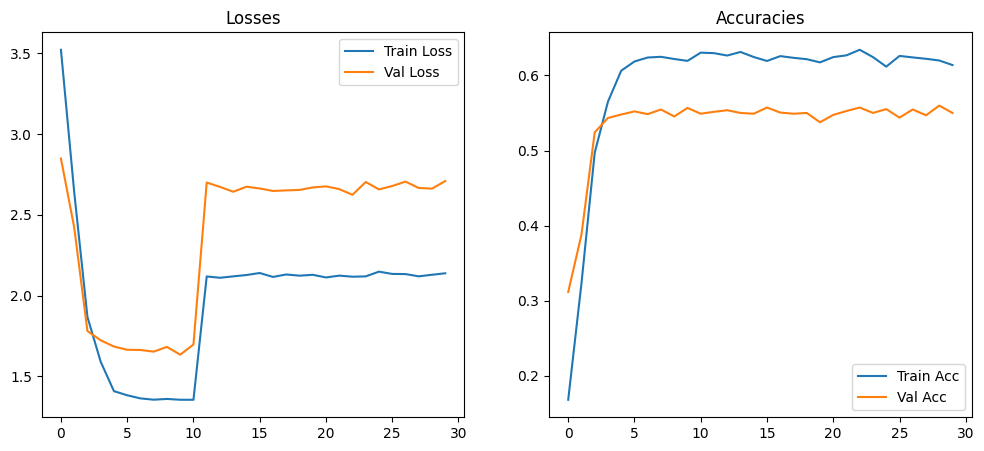

In [9]:
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)

model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)

# model = models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_e = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_e.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_e, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

In [10]:
val_accuracies_e

[0.31166150670794635,
 0.38802889576883387,
 0.5242518059855521,
 0.5433436532507739,
 0.5479876160990712,
 0.5521155830753354,
 0.5485036119711042,
 0.5546955624355006,
 0.5454076367389061,
 0.5567595459236326,
 0.5490196078431373,
 0.5515995872033024,
 0.5536635706914345,
 0.5500515995872033,
 0.5490196078431373,
 0.5572755417956656,
 0.5505675954592363,
 0.5490196078431373,
 0.5500515995872033,
 0.5376676986584107,
 0.5474716202270382,
 0.5526315789473685,
 0.5572755417956656,
 0.5500515995872033,
 0.5552115583075335,
 0.543859649122807,
 0.5546955624355006,
 0.5469556243550051,
 0.5598555211558307,
 0.5500515995872033]

100%|██████████| 237/237 [00:48<00:00,  4.88it/s]


Epoch 1/7 | Train Loss: 2.9036 | Train Acc: 0.2985 | Val Loss: 1.9812 | Val Acc: 0.4773
Best model saved.


100%|██████████| 237/237 [00:47<00:00,  5.02it/s]


Epoch 2/7 | Train Loss: 1.8659 | Train Acc: 0.4896 | Val Loss: 1.8031 | Val Acc: 0.5243
Best model saved.


100%|██████████| 237/237 [00:47<00:00,  5.03it/s]


Epoch 3/7 | Train Loss: 1.2082 | Train Acc: 0.6528 | Val Loss: 1.2949 | Val Acc: 0.6362
Best model saved.


100%|██████████| 237/237 [00:46<00:00,  5.05it/s]


Epoch 4/7 | Train Loss: 0.9558 | Train Acc: 0.7217 | Val Loss: 1.2250 | Val Acc: 0.6527
Best model saved.


100%|██████████| 237/237 [00:46<00:00,  5.06it/s]


Epoch 5/7 | Train Loss: 0.8364 | Train Acc: 0.7611 | Val Loss: 1.2114 | Val Acc: 0.6605
Best model saved.


100%|██████████| 237/237 [00:46<00:00,  5.06it/s]


Epoch 6/7 | Train Loss: 0.8183 | Train Acc: 0.7627 | Val Loss: 1.2087 | Val Acc: 0.6589


100%|██████████| 237/237 [00:46<00:00,  5.07it/s]


Epoch 7/7 | Train Loss: 0.8056 | Train Acc: 0.7680 | Val Loss: 1.2025 | Val Acc: 0.6584


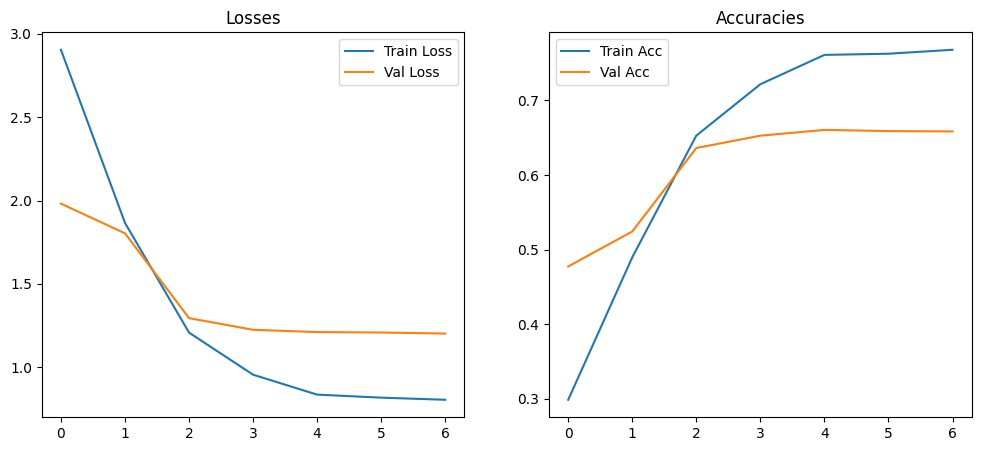

In [16]:
# transform = A.Compose([
#     A.Resize(height=224, width=224),
#     A.HorizontalFlip(p=0.5),
#     A.VerticalFlip(p=0.5),
#     A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
#     ToTensorV2(),
# ])

# transform = A.Compose([
#     A.RandomCrop(width=32, height=32, p=1.0, always_apply=True), # Обязательно обрезаем до 32x32
#     A.HorizontalFlip(p=0.5),  # Горизонтальный разворот (50% вероятность)
#     A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.3), # Сдвиг, масштабирование, поворот (30%)
#     A.CoarseDropout(max_holes=1, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, fill_value=mean, p=0.2), # CoarseDropout (20%)
#     A.Normalize(mean=mean, std=std), # Нормализация (обязательно)
#     ToTensorV2(), # Преобразование в тензор (обязательно)
# ])

# test_transform = A.Compose([
#     A.Resize(height=224, width=224),
#     A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
#     ToTensorV2(),
# ])

transform = A.Compose([
    A.Resize(height=224, width=224),  # Размер, с которым тренировалась EfficientNet_B7
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.4), # Более интенсивные преобразования
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

# Трансформации для тестового набора
test_transform = A.Compose([
    A.Resize(height=224, width=224),  # Соответствует размеру в train
    #A.CenterCrop(height=512, width=512), # CenterCrop, так как EfficientNet_B7 была обучена на изображениях размером 512x512
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)

model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_e2 = []

num_epochs = 7

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_e2.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_e2, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

In [20]:
val_accuracies_e2

[0.47729618163054693,
 0.5242518059855521,
 0.6362229102167183,
 0.652734778121775,
 0.6604747162022704,
 0.6589267285861713,
 0.6584107327141383]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:04<00:00, 59.7MB/s] 
100%|██████████| 237/237 [02:41<00:00,  1.47it/s]


Epoch 1/7 | Train Loss: 3.1274 | Train Acc: 0.2557 | Val Loss: 3.1996 | Val Acc: 0.2998
Best model saved.


100%|██████████| 237/237 [02:43<00:00,  1.45it/s]


Epoch 2/7 | Train Loss: 2.0256 | Train Acc: 0.4569 | Val Loss: 2.2286 | Val Acc: 0.4520
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.45it/s]


Epoch 3/7 | Train Loss: 1.2397 | Train Acc: 0.6495 | Val Loss: 1.3101 | Val Acc: 0.6398
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 4/7 | Train Loss: 0.9264 | Train Acc: 0.7294 | Val Loss: 1.2410 | Val Acc: 0.6538
Best model saved.


100%|██████████| 237/237 [02:43<00:00,  1.45it/s]


Epoch 5/7 | Train Loss: 0.7849 | Train Acc: 0.7719 | Val Loss: 1.2089 | Val Acc: 0.6651
Best model saved.


100%|██████████| 237/237 [02:41<00:00,  1.46it/s]


Epoch 6/7 | Train Loss: 0.7640 | Train Acc: 0.7789 | Val Loss: 1.1911 | Val Acc: 0.6662
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 7/7 | Train Loss: 0.7411 | Train Acc: 0.7850 | Val Loss: 1.1910 | Val Acc: 0.6672
Best model saved.


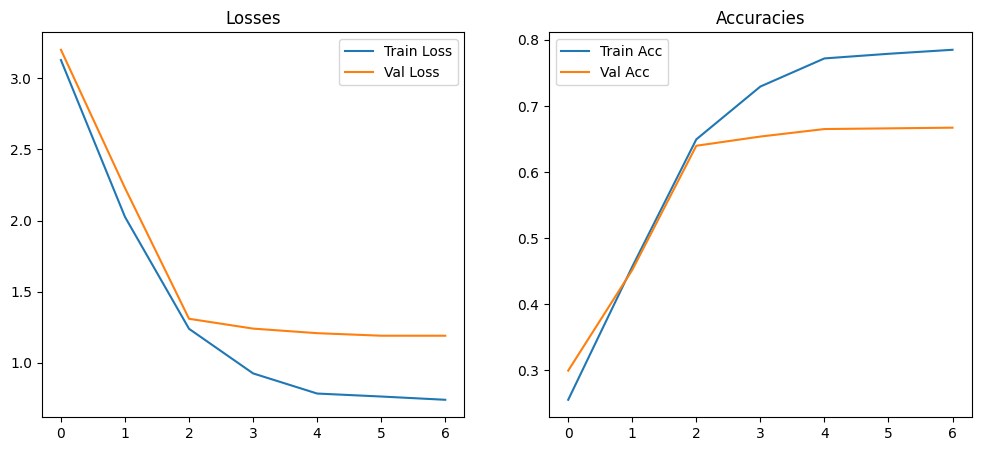

In [21]:
transform = A.Compose([
    A.Resize(height=224, width=224), 
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.4), 
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224), 
    #A.CenterCrop(height=512, width=512),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)

model = models.efficientnet_b7(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_e2 = []

num_epochs = 7

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_e2.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_e2, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

## GAN

In [24]:
class Generator(nn.Module):
    def __init__(self, noise_dim, num_classes):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        x = torch.cat((noise, label_input), dim=1)
        out = self.model(x)
        return out.view(-1, 3, 32, 32)

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32 + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, imgs, labels):
        label_input = self.label_emb(labels)
        imgs_flat = imgs.view(imgs.size(0), -1)
        x = torch.cat((imgs_flat, label_input), dim=1)
        return self.model(x)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[GAN Epoch 1] D Loss: 0.0390, G Loss: 7.5193
[GAN Epoch 2] D Loss: 0.0212, G Loss: 4.7386
[GAN Epoch 3] D Loss: 0.1442, G Loss: 1.9066
[GAN Epoch 4] D Loss: 0.0465, G Loss: 3.5141
[GAN Epoch 5] D Loss: 0.0255, G Loss: 3.5433


100%|██████████| 237/237 [00:09<00:00, 25.20it/s]


Epoch 1/30 | Train Loss: 3.9334 | Train Acc: 0.1036 | Val Loss: 3.3136 | Val Acc: 0.1760
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 28.28it/s]


Epoch 2/30 | Train Loss: 3.2725 | Train Acc: 0.1842 | Val Loss: 3.0122 | Val Acc: 0.2291
Best model saved.


100%|██████████| 237/237 [00:14<00:00, 15.89it/s]


Epoch 3/30 | Train Loss: 2.6046 | Train Acc: 0.2949 | Val Loss: 2.5091 | Val Acc: 0.3437
Best model saved.


100%|██████████| 237/237 [00:20<00:00, 11.39it/s]


Epoch 4/30 | Train Loss: 2.3685 | Train Acc: 0.3458 | Val Loss: 2.4234 | Val Acc: 0.3705
Best model saved.


100%|██████████| 237/237 [00:13<00:00, 17.14it/s]


Epoch 5/30 | Train Loss: 2.2177 | Train Acc: 0.3841 | Val Loss: 2.3973 | Val Acc: 0.3746
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 29.40it/s]


Epoch 6/30 | Train Loss: 2.1650 | Train Acc: 0.3907 | Val Loss: 2.3774 | Val Acc: 0.3803
Best model saved.


100%|██████████| 237/237 [00:07<00:00, 30.27it/s]


Epoch 7/30 | Train Loss: 2.1667 | Train Acc: 0.3951 | Val Loss: 2.3738 | Val Acc: 0.3824
Best model saved.


100%|██████████| 237/237 [00:08<00:00, 28.18it/s]


Epoch 8/30 | Train Loss: 2.1537 | Train Acc: 0.4005 | Val Loss: 2.3697 | Val Acc: 0.3798


100%|██████████| 237/237 [00:09<00:00, 24.38it/s]


Epoch 9/30 | Train Loss: 2.1442 | Train Acc: 0.4062 | Val Loss: 2.3780 | Val Acc: 0.3849
Best model saved.


100%|██████████| 237/237 [00:13<00:00, 17.16it/s]


Epoch 10/30 | Train Loss: 2.1523 | Train Acc: 0.3974 | Val Loss: 2.3746 | Val Acc: 0.3777


100%|██████████| 237/237 [00:09<00:00, 25.15it/s]


Epoch 11/30 | Train Loss: 2.1391 | Train Acc: 0.4032 | Val Loss: 2.3939 | Val Acc: 0.3762
Switched to Label Smoothing Loss


100%|██████████| 237/237 [00:14<00:00, 16.25it/s]


Epoch 12/30 | Train Loss: 2.7990 | Train Acc: 0.4010 | Val Loss: 2.9634 | Val Acc: 0.3725


100%|██████████| 237/237 [00:11<00:00, 19.77it/s]


Epoch 13/30 | Train Loss: 2.8045 | Train Acc: 0.4061 | Val Loss: 2.9628 | Val Acc: 0.3777


100%|██████████| 237/237 [00:08<00:00, 27.80it/s]


Epoch 14/30 | Train Loss: 2.8151 | Train Acc: 0.3981 | Val Loss: 2.9692 | Val Acc: 0.3818


100%|██████████| 237/237 [00:08<00:00, 26.81it/s]


Epoch 15/30 | Train Loss: 2.8158 | Train Acc: 0.3904 | Val Loss: 2.9643 | Val Acc: 0.3818


100%|██████████| 237/237 [00:08<00:00, 26.84it/s]


Epoch 16/30 | Train Loss: 2.8153 | Train Acc: 0.4005 | Val Loss: 2.9547 | Val Acc: 0.3824
Early stopping triggered.


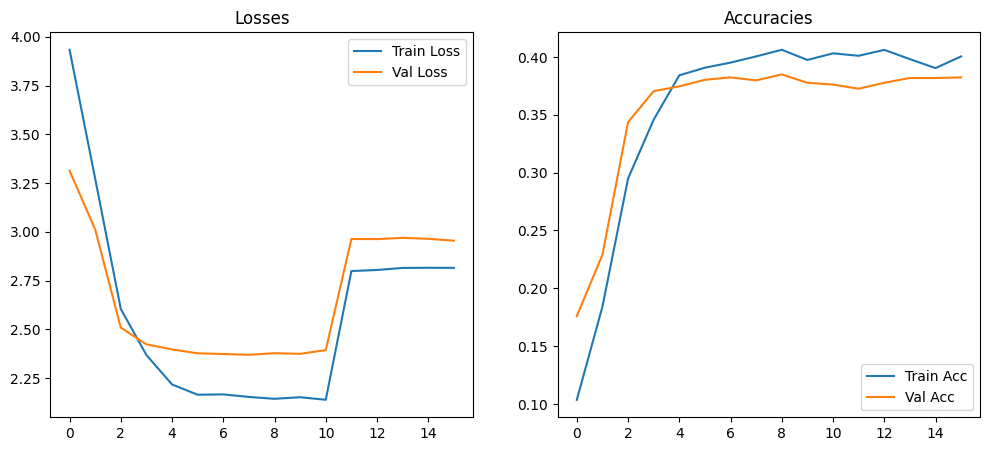

In [10]:
#Пайплайн
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)

#GAN
noise_dim = 100
generator = Generator(noise_dim, num_classes).to(device)
discriminator = Discriminator(num_classes).to(device)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
gan_loss = nn.BCELoss()

for epoch in range(5):
    for real_imgs, labels in train_loader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, noise_dim).to(device)
        gen_imgs = generator(z, labels)

        real_loss = gan_loss(discriminator(real_imgs, labels), valid)
        fake_loss = gan_loss(discriminator(gen_imgs.detach(), labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        z = torch.randn(batch_size, noise_dim).to(device)
        gen_imgs = generator(z, labels)
        g_loss = gan_loss(discriminator(gen_imgs, labels), valid)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"[GAN Epoch {epoch+1}] D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_g = []

num_epochs = 30

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        synthetic_count = images.size(0) // 2
        z = torch.randn(synthetic_count, noise_dim).to(device)
        fake_labels = torch.randint(0, num_classes, (synthetic_count,)).to(device)
        fake_images = generator(z, fake_labels)

        images = torch.cat((images, fake_images), dim=0)
        labels = torch.cat((labels, fake_labels), dim=0)

        outputs = model(images)
        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_g.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 10:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_g, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

In [12]:
val_accuracies = [0.2961816305469556, 0.3782249742002064, 0.49484004127966974, 0.5154798761609907, 0.5319917440660474,
 0.5330237358101135, 0.5335397316821465, 0.5319917440660474, 0.5299277605779154, 0.5361197110423117, 0.5319917440660474,
 0.5319917440660474, 0.5319917440660474, 0.5314757481940144, 0.5381836945304438, 0.5304437564499485, 0.536119711042317,
 0.5376676986584107, 0.5381836945304438, 0.5356037151702786, 0.5294117647058824, 0.5309597523219814, 0.5304437564499485,
 0.5288957688338494, 0.5345717234262126, 0.5381836945304438, 0.5371517027863777, 0.5340557275541795, 0.5366357069143447,
 0.5278637770897833] #accuracy из mobilenet_v2

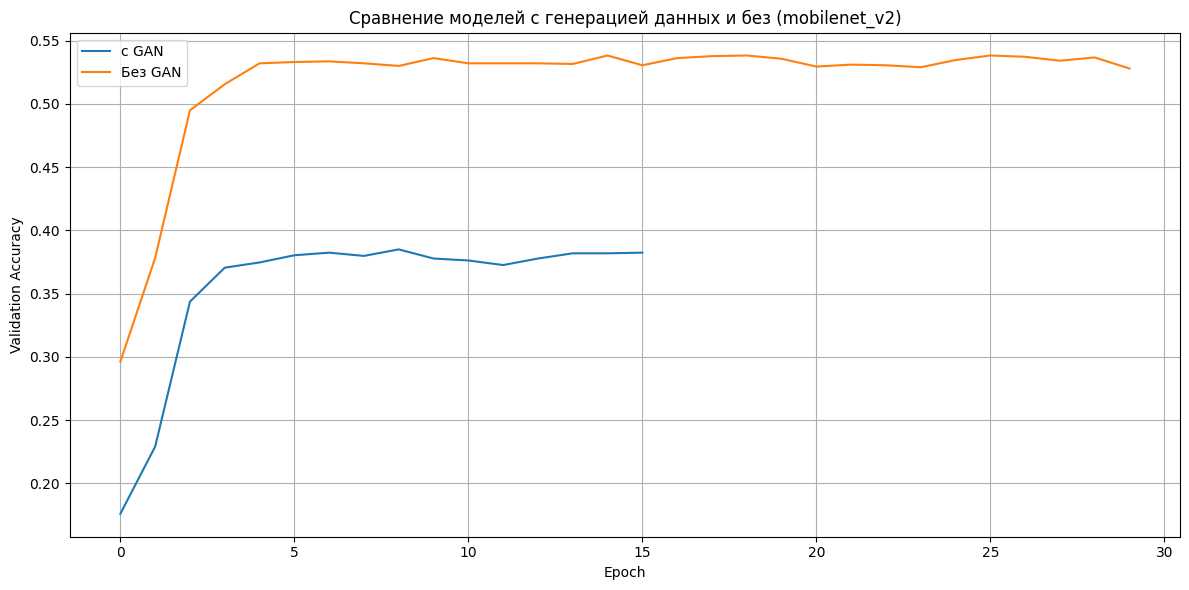

In [13]:
plt.figure(figsize=(12, 6))

plt.plot(val_accuracies_g, label='c GAN')
plt.plot(val_accuracies, label='Без GAN')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Сравнение моделей с генерацией данных и без (mobilenet_v2)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Для загрузки test на кагл

In [22]:
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.image_paths = sorted(
            [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))],
            key=lambda x: int(os.path.basename(x).split('.')[0])
        )
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

test_dataset = TestDataset(test_dir, transform=AlbumentationsTransform(test_transform))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
predictions = []
image_names = []

with torch.no_grad():
    for inputs, names in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        image_names.extend(names)


ids = [int(name.split('.')[0]) for name in image_names]

submission = pd.DataFrame({
    'id': ids,
    'label': predictions
})
submission = submission.sort_values('id')

sample_submission['target'] = submission['label']
sample_submission.to_csv('submission.csv', index=False)

100%|██████████| 61/61 [00:33<00:00,  1.83it/s]


In [23]:
sample_submission

id  target
0        0      71
1        1      62
2        2      39
3        3      41
4        4      66
...    ...     ...
3873  3873      67
3874  3874      92
3875  3875      95
3876  3876      91
3877  3877      75

[3878 rows x 2 columns]

In [19]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#train_data.classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 237/237 [02:42<00:00,  1.45it/s]


Epoch 1/12 | Train Loss: 3.0119 | Train Acc: 0.2784 | Val Loss: 3.0980 | Val Acc: 0.2921


IOStream.flush timed out


Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 2/12 | Train Loss: 1.9359 | Train Acc: 0.4832 | Val Loss: 2.4197 | Val Acc: 0.4035
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 3/12 | Train Loss: 1.2241 | Train Acc: 0.6499 | Val Loss: 1.2565 | Val Acc: 0.6476
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 4/12 | Train Loss: 0.8934 | Train Acc: 0.7348 | Val Loss: 1.1632 | Val Acc: 0.6801
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 5/12 | Train Loss: 0.7494 | Train Acc: 0.7776 | Val Loss: 1.1412 | Val Acc: 0.6868
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 6/12 | Train Loss: 0.7268 | Train Acc: 0.7867 | Val Loss: 1.1281 | Val Acc: 0.6873
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 7/12 | Train Loss: 0.7046 | Train Acc: 0.7896 | Val Loss: 1.1276 | Val Acc: 0.6894
Best model saved.
Switched to Label Smoothing Loss


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 8/12 | Train Loss: 1.6465 | Train Acc: 0.7923 | Val Loss: 2.1202 | Val Acc: 0.6894


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 9/12 | Train Loss: 1.6366 | Train Acc: 0.7962 | Val Loss: 2.1167 | Val Acc: 0.6904
Best model saved.


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 10/12 | Train Loss: 1.6500 | Train Acc: 0.7931 | Val Loss: 2.1188 | Val Acc: 0.6889


100%|██████████| 237/237 [02:43<00:00,  1.45it/s]


Epoch 11/12 | Train Loss: 1.6238 | Train Acc: 0.7994 | Val Loss: 2.1178 | Val Acc: 0.6878


100%|██████████| 237/237 [02:42<00:00,  1.46it/s]


Epoch 12/12 | Train Loss: 1.6337 | Train Acc: 0.8019 | Val Loss: 2.1210 | Val Acc: 0.6899


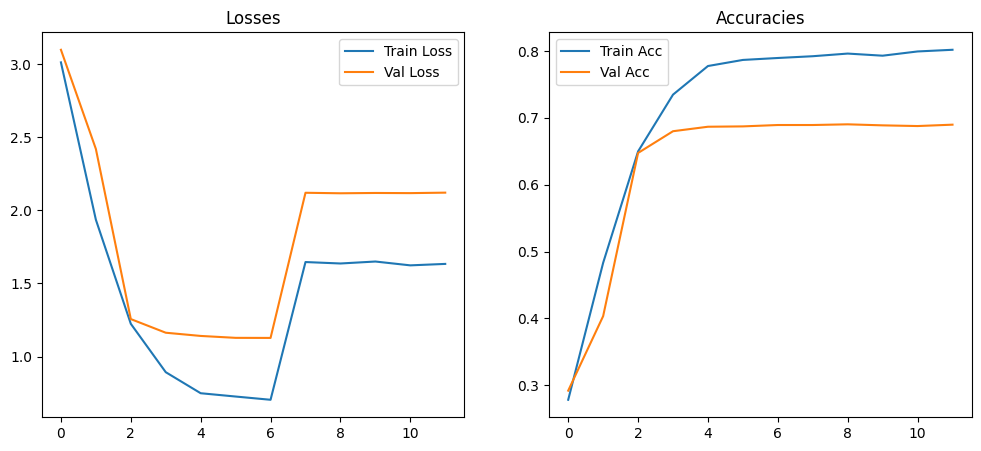

100%|██████████| 61/61 [00:27<00:00,  2.24it/s]


In [28]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.image as mpimg
import hashlib
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import shutil
from torchvision.datasets import ImageFolder


data_dir = 'data/train'
train_dir = 'data/split/train'
val_dir = 'data/split/val'
test_dir = 'data/test'

# Создание новых директорий
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Проход по каждому классу
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

class SortedImageFolder(ImageFolder): #для правильной сортировки классов
    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir()]
        classes = sorted(classes, key=lambda x: int(x))
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

class AlbumentationsTransform:
    def __init__(self, augmentations):
        self.augmentations = augmentations

    def __call__(self, img):
        img = np.array(img)
        augmented = self.augmentations(image=img)
        return augmented['image']
    


transform = A.Compose([
    A.Resize(height=224, width=224, interpolation=cv2.INTER_LINEAR), 
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.4), 
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(height=224, width=224), 
    #A.CenterCrop(height=512, width=512),
    A.Normalize(mean=(0.5069, 0.4869, 0.4403), std=(0.1999, 0.1975, 0.2014)),
    ToTensorV2(),
])

#Данные
train_data = SortedImageFolder(train_dir, transform=AlbumentationsTransform(transform))
val_data = SortedImageFolder(val_dir, transform=AlbumentationsTransform(test_transform))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Предобученная модель
num_classes = len(train_data.classes)

model = models.efficientnet_b7(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, num_classes)
model = model.to(device)

#2 лося
criterion_1 = nn.CrossEntropyLoss()
criterion_2 = nn.CrossEntropyLoss(label_smoothing=0.1)

#Оптимайзер
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Шедулер
sheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

#Ранняя остановка
early_stopping = EarlyStopping(patience=7)


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies_e2 = []

num_epochs = 12

best_val_acc = 0
use_label_smoothing = False

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)

        loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_acc)

    #На валидации
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion_2(outputs, labels) if use_label_smoothing else criterion_1(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_losses.append(val_loss / len(val_loader))
    val_accuracies_e2.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc:.4f}")

    #Сохранение лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Best model saved.")

    #Шедулер
    sheduler.step()

    #Свитч лося
    if epoch == 6:
        use_label_smoothing = True
        print("Switched to Label Smoothing Loss")

    #Ранняя остановка
    early_stopping(val_acc)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

#Графики
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies_e2, label='Val Acc')
plt.title('Accuracies')
plt.legend()

plt.show()

class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.image_paths = sorted(
            [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.lower().endswith(('.jpg', '.jpeg', '.png'))],
            key=lambda x: int(os.path.basename(x).split('.')[0])
        )
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)

test_dataset = TestDataset(test_dir, transform=AlbumentationsTransform(test_transform))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()
predictions = []
image_names = []

with torch.no_grad():
    for inputs, names in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        image_names.extend(names)


ids = [int(name.split('.')[0]) for name in image_names]

submission = pd.DataFrame({
    'id': ids,
    'label': predictions
})
submission = submission.sort_values('id')

sample_submission['target'] = submission['label']
sample_submission.to_csv('submission.csv', index=False)

## Итог на кагле